# Importing modules and dependences

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

# Loading VDFs and augmenting them with the particle abundances and power spectrum

In [2]:
featurevector_allvdfs_all_4040 = np.load('allsimulations.mldata_vdfs_4040.npy')
featurevector_allvdfs_all_6060 = np.load('allsimulations.mldata_vdfs_6060.npy')
print(featurevector_allvdfs_all_4040.shape)
print(featurevector_allvdfs_all_6060.shape)

(1596, 2, 40, 40)
(1596, 2, 60, 60)


In [3]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_allps.npy')
print(featurevector_allmoments.shape)
extra_features = featurevector_allmoments[:,18:]

(1596, 30)


In [4]:
ncases = featurevector_allvdfs_all_4040.shape[0]
featurevector_allvdfs_all_4040_norm = np.copy(np.log10(featurevector_allvdfs_all_4040 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_4040_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_4040_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_4040_norm[ncase,1,:,:])

ncases = featurevector_allvdfs_all_6060.shape[0]
featurevector_allvdfs_all_6060_norm = np.copy(np.log10(featurevector_allvdfs_all_6060 + 1))
for ncase in range (0, ncases, 1):
  featurevector_allvdfs_all_6060_norm[ncase,0,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,0,:,:])
  if (np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:]) != 0):
    featurevector_allvdfs_all_6060_norm[ncase,1,:,:] /= np.amax(featurevector_allvdfs_all_6060_norm[ncase,1,:,:])

In [5]:
ncases = featurevector_allvdfs_all_4040_norm.shape[0]
featurevector_allvdfs_all_4040_aug = np.zeros([ncases,2*40*40+12], dtype=float)
featurevector_allvdfs_all_4040_aug[:,:-12] = np.log10(featurevector_allvdfs_all_4040_norm.reshape(featurevector_allvdfs_all_4040_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_4040_aug[:,-12:] = extra_features

ncases = featurevector_allvdfs_all_6060_norm.shape[0]
featurevector_allvdfs_all_6060_aug = np.zeros([ncases,2*60*60+12], dtype=float)
featurevector_allvdfs_all_6060_aug[:,:-12] = np.log10(featurevector_allvdfs_all_6060_norm.reshape(featurevector_allvdfs_all_6060_norm.shape[0], -1) + 1)
featurevector_allvdfs_all_6060_aug[:,-12:] = extra_features

print(featurevector_allvdfs_all_4040_aug.shape)
print(featurevector_allvdfs_all_6060_aug.shape)
print(np.amin(featurevector_allvdfs_all_6060_aug[:,-10:]))
print(np.amax(featurevector_allvdfs_all_6060_aug[:,-10:]))

(1596, 3212)
(1596, 7212)
0.00020191832627305094
1.0


In [6]:
featurevector_allmoments = np.load('allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('allsimulations.timep_array_all.npy')
labels_an = np.load('allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

print(labels_allmoments.shape)

The total number of data points is: 1596
Among them unstable (positive) samples: 418
(1596,)


In [7]:
simnames = np.load('allsimulations.simnames_all.npy')

In [8]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x7e1bf100ae40>

# Best architecture for 40x40 VDFs (5-fold CV for faster assessment)

In [9]:
class VDFCNN_4040_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*5*5+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 5 * 5)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*10*10+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 10 * 10)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_4040_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_4040_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*20*20+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 40, 40)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 20 * 20)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

In [10]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

100%|██████████| 2000/2000 [01:26<00:00, 23.14it/s]


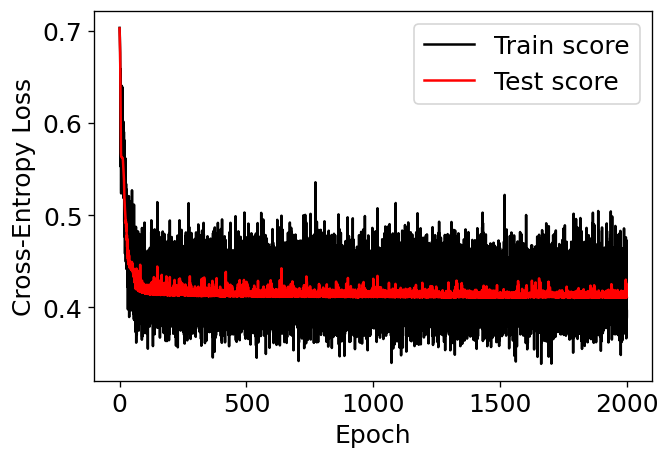

250 0.9013282732447818 0.6538490897293996
500 0.9013282732447818 0.6538490897293996
750 0.8994307400379506 0.6513110186634098
1000 0.8861480075901328 0.6385252471279722
1250 0.8956356736242884 0.6512156024579214
1500 0.9013282732447818 0.6538490897293996
1750 0.9013282732447818 0.6538490897293996
---------------------------------------------


100%|██████████| 2000/2000 [01:24<00:00, 23.58it/s]


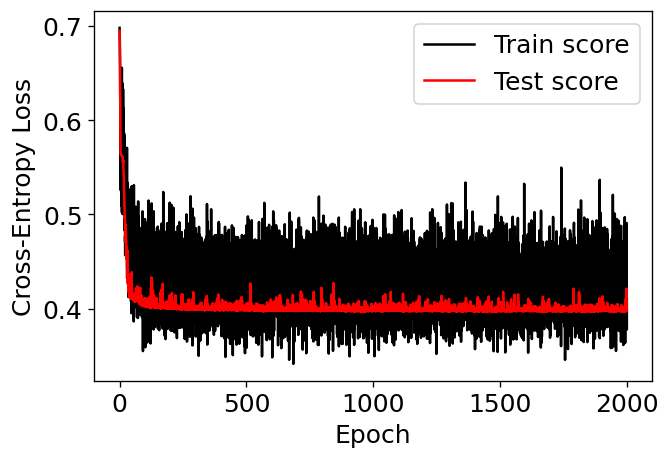

250 0.9127134724857685 0.6840196939048128
500 0.9108159392789373 0.681481622838823
750 0.9165085388994307 0.7040380138162665
1000 0.9165085388994307 0.7040380138162665
1250 0.9146110056925996 0.6965192168237854
1500 0.9165085388994307 0.6990572878897752
1750 0.9108159392789373 0.6765008969123315
---------------------------------------------


100%|██████████| 2000/2000 [01:24<00:00, 23.74it/s]


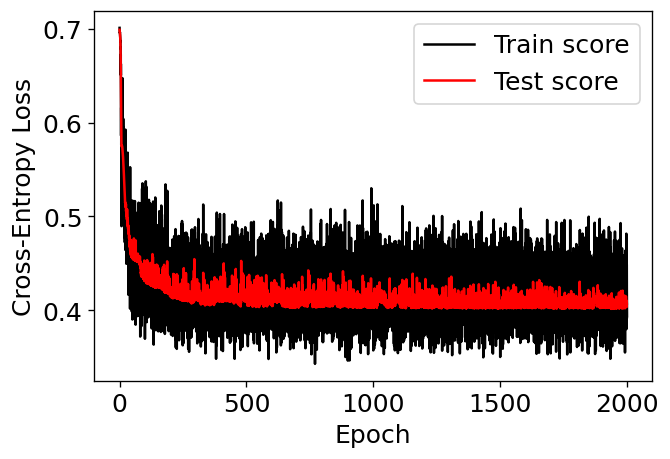

250 0.9089184060721063 0.6869947341096194
500 0.9070208728652751 0.6798004895053029
750 0.8766603415559773 0.6339464510865535
1000 0.9070208728652751 0.66594971445524
1250 0.8823529411764706 0.6462953348661277
1500 0.9089184060721063 0.6685270340428688
1750 0.9108159392789373 0.6849551286805607
---------------------------------------------


100%|██████████| 2000/2000 [01:25<00:00, 23.43it/s]


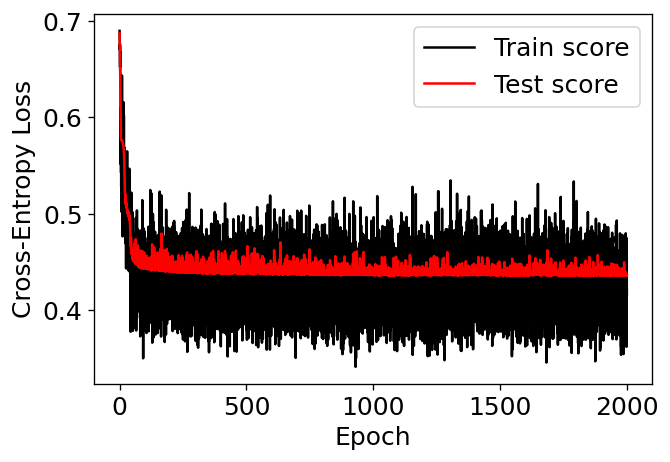

250 0.8785578747628083 0.6021225544481358
500 0.8747628083491461 0.6060723514211886
750 0.8823529411764706 0.6164082687338501
1000 0.872865275142315 0.5806939830195644
1250 0.8671726755218216 0.559265411590993
1500 0.8747628083491461 0.5878368401624215
1750 0.8823529411764706 0.6164082687338501
---------------------------------------------


100%|██████████| 2000/2000 [01:25<00:00, 23.41it/s]


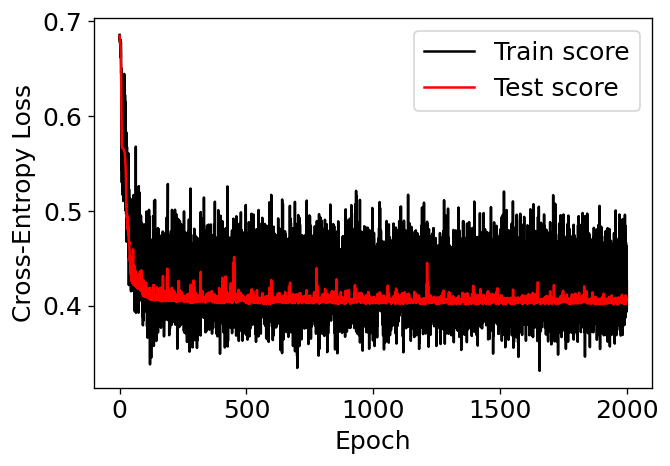

250 0.905123339658444 0.6662109300824124
500 0.905123339658444 0.6858835593027229
750 0.905123339658444 0.6858835593027229
1000 0.9089184060721063 0.690972617826896
1250 0.9070208728652751 0.6638373020394212
1500 0.905123339658444 0.6662109300824124
1750 0.9089184060721063 0.6860544605218184
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 92.4+/-3.1368774282716245
TN = 382.6+/-4.841487374764082
FP = 8.6+/-2.4166091947189146
FN = 43.4+/-3.9293765408777004
Acc = 0.9013282732447816+/-0.01200105373877944
TSS = 0.658639400454876+/-0.030733087259738782
=>=>=> NUMBER OF EPOCHS: 500
TP = 93.4+/-2.727636339397171
TN = 380.8+/-5.878775382679627
FP = 10.4+/-3.7735924528226414
FN = 42.4+/-3.7202150475476548
Acc = 0.8998102466793169+/-0.012892059014393184
TSS = 0.6614174225594873+/-0.02986455320761608
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.8+/-2.7129319932501073
TN = 378.4+/-7.552483035399681
FP = 12.8+/-5.035871324805669
FN = 42.0+/-4.289

In [11]:
# NETWORK: VDFCNN_4040_CNN3_CONN2
ARCH = 'VDFCNN_4040_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:20<00:00, 24.71it/s]


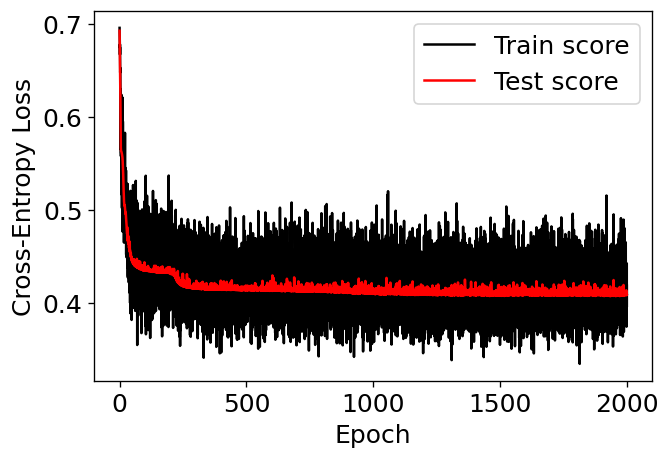

250 0.8766603415559773 0.6208541658715316
500 0.9013282732447818 0.6538490897293996
750 0.9013282732447818 0.6538490897293996
1000 0.905123339658444 0.6489637800083966
1250 0.8994307400379506 0.6513110186634098
1500 0.905123339658444 0.6589252318613793
1750 0.9070208728652751 0.6614633029273691
---------------------------------------------


100%|██████████| 2000/2000 [01:19<00:00, 25.23it/s]


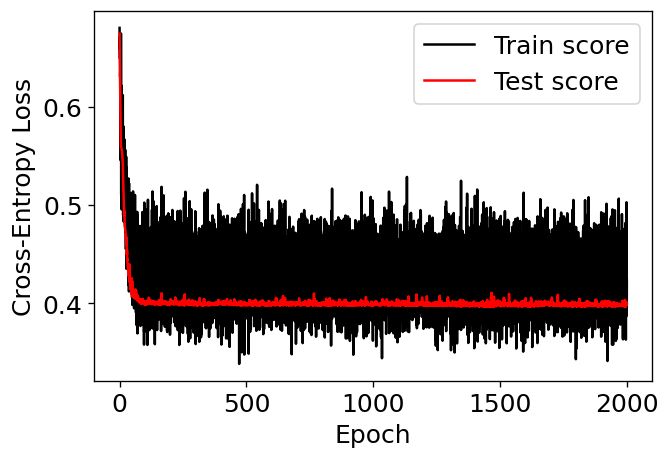

250 0.9108159392789373 0.6765008969123315
500 0.9127134724857685 0.6840196939048128
750 0.9146110056925996 0.7014999427502767
1000 0.9108159392789373 0.681481622838823
1250 0.9146110056925996 0.6965192168237854
1500 0.9165085388994307 0.7040380138162665
1750 0.9146110056925996 0.6815770390443112
---------------------------------------------


100%|██████████| 2000/2000 [01:21<00:00, 24.64it/s]


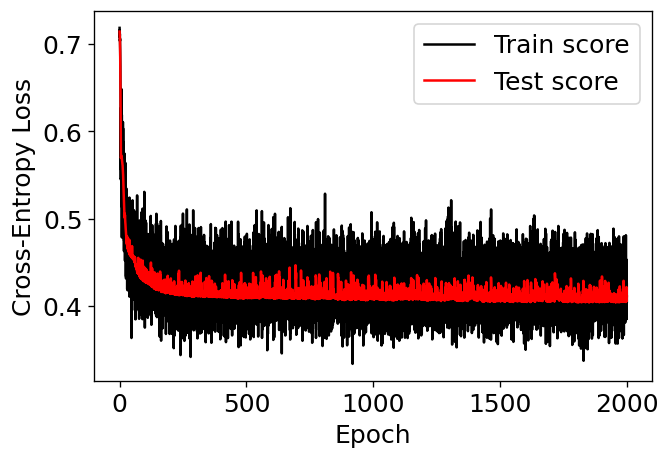

250 0.9013282732447818 0.676685455759104
500 0.9032258064516129 0.6607950752799823
750 0.9013282732447818 0.676685455759104
1000 0.9032258064516129 0.6607950752799823
1250 0.9108159392789373 0.6895720536972483
1500 0.9032258064516129 0.6607950752799823
1750 0.9089184060721063 0.6869947341096194
---------------------------------------------


100%|██████████| 2000/2000 [01:21<00:00, 24.68it/s]


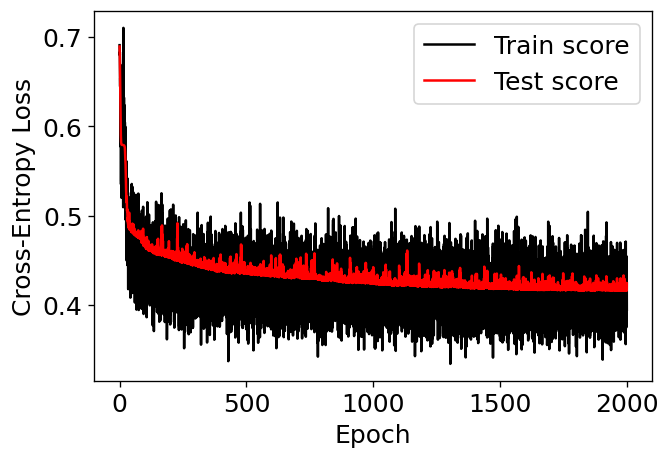

250 0.857685009487666 0.6101698043558509
500 0.8823529411764706 0.6437615356220007
750 0.8842504743833017 0.6645810262089332
1000 0.8652751423149905 0.5612403100775194
1250 0.8956356736242884 0.6755260243632337
1500 0.8861480075901328 0.6808416389811739
1750 0.8956356736242884 0.6846437799926172
---------------------------------------------


100%|██████████| 2000/2000 [01:20<00:00, 24.71it/s]


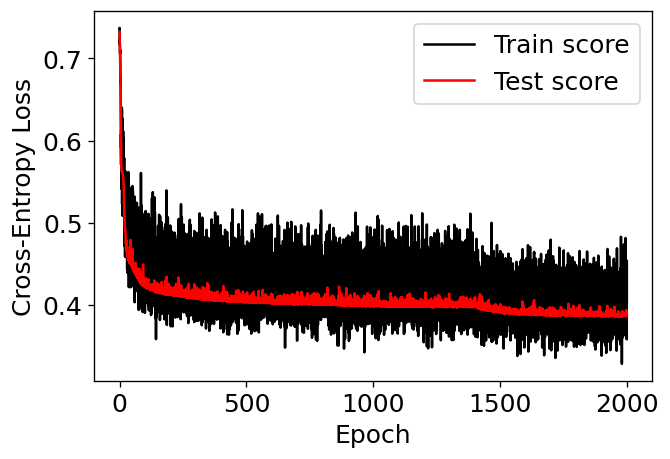

250 0.9089184060721063 0.7253997189624397
500 0.9146110056925996 0.7428696213588546
750 0.9070208728652751 0.7326915043105086
1000 0.9108159392789373 0.7377805628346816
1250 0.9070208728652751 0.6933462458698871
1500 0.9278937381404174 0.7459268542782271
1750 0.9240986717267552 0.7260833238388212
---------------------------------------------
ARCH = VDFCNN_4040_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 96.0+/-4.604345773288535
TN = 373.6+/-10.707007051459337
FP = 17.6+/-9.00222194794152
FN = 39.8+/-4.48998886412873
Acc = 0.8910815939278939+/-0.020668309380174724
TSS = 0.6619220083722516+/-0.042011382790380074
=>=>=> NUMBER OF EPOCHS: 500
TP = 95.8+/-5.114684741017769
TN = 380.0+/-7.014271166700073
FP = 11.2+/-5.344155686354955
FN = 40.0+/-5.727128425310541
Acc = 0.9028462998102466+/-0.01147340907615254
TSS = 0.67705900317901+/-0.035472314441961174
=>=>=> NUMBER OF EPOCHS: 750
TP = 98.0+/-5.019960159204453
TN = 377.2+/-7.807688518377254
FP = 14.0+/-5.830951894845301
FN = 37.8+/-4.8332

In [12]:
# NETWORK: VDFCNN_4040_CNN3_CONN1
ARCH = 'VDFCNN_4040_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:17<00:00, 25.93it/s]


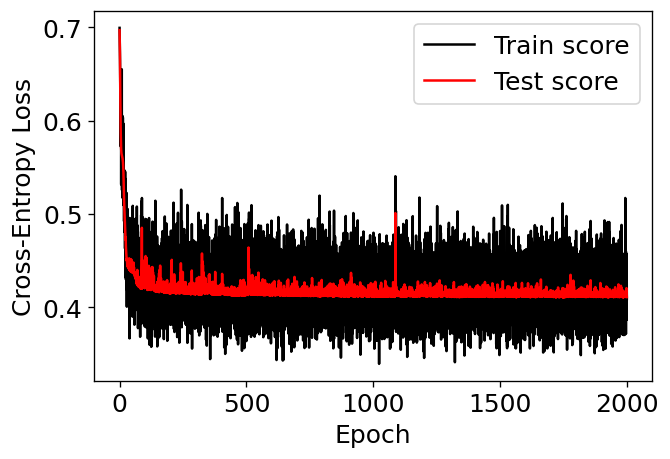

250 0.9013282732447818 0.6438876378764169
500 0.8956356736242884 0.6462348765314301
750 0.9013282732447818 0.6389069119499255
1000 0.9013282732447818 0.6389069119499255
1250 0.9032258064516129 0.6414449830159155
1500 0.8975332068311196 0.6437922216709286
1750 0.8956356736242884 0.6462348765314301
---------------------------------------------


100%|██████████| 2000/2000 [01:17<00:00, 25.94it/s]


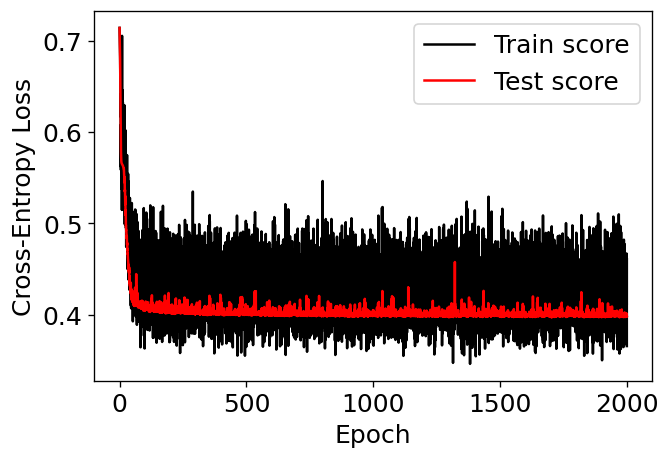

250 0.9089184060721063 0.6590206480668677
500 0.9127134724857685 0.6740582420518301
750 0.9165085388994307 0.6890958360367925
1000 0.9184060721062619 0.6966146330292736
1250 0.9165085388994307 0.6990572878897752
1500 0.9165085388994307 0.6990572878897752
1750 0.9165085388994307 0.6990572878897752
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.05it/s]


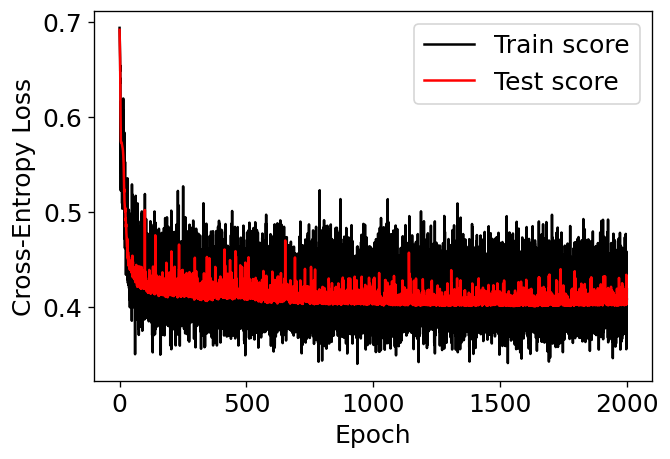

250 0.8956356736242884 0.632018096862716
500 0.9070208728652751 0.66594971445524
750 0.9089184060721063 0.6777608840762442
1000 0.9070208728652751 0.6844174145219906
1250 0.9070208728652751 0.6890343395386783
1500 0.905123339658444 0.6864570199510495
1750 0.905123339658444 0.6864570199510495
---------------------------------------------


100%|██████████| 2000/2000 [01:16<00:00, 26.15it/s]


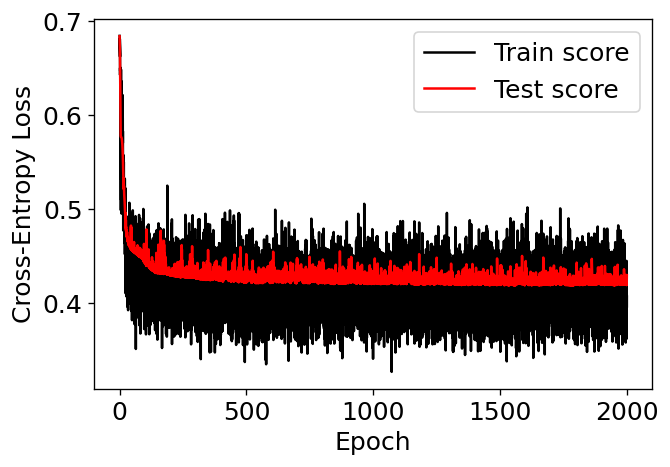

250 0.888045540796964 0.6150424510889627
500 0.8842504743833017 0.6189922480620156
750 0.8785578747628083 0.6112403100775194
1000 0.889943074003795 0.6039497969730528
1250 0.8633776091081594 0.5905684754521964
1500 0.8975332068311196 0.6370801033591732
1750 0.8956356736242884 0.6299372462163161
---------------------------------------------


100%|██████████| 2000/2000 [01:18<00:00, 25.57it/s]


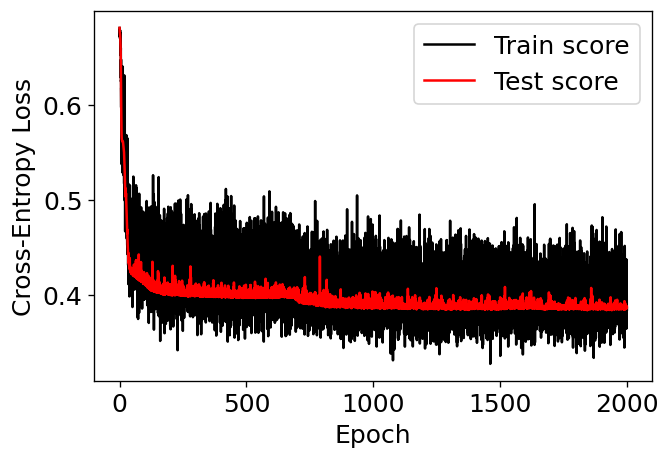

250 0.920303605313093 0.7505032091451141
500 0.9089184060721063 0.7303178762675174
750 0.9089184060721063 0.7008089324370513
1000 0.9240986717267552 0.7260833238388212
1250 0.9335863377609108 0.7683149139797197
1500 0.9297912713472486 0.7533895408453913
1750 0.9316888045540797 0.7559340701074779
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 92.2+/-6.43117407632541
TN = 383.6+/-4.223742416388575
FP = 7.6+/-3.006659275674582
FN = 43.6+/-7.735631842325487
Acc = 0.9028462998102468+/-0.011090428232411725
TSS = 0.6600944086080156+/-0.04744580434837414
=>=>=> NUMBER OF EPOCHS: 500
TP = 94.0+/-5.176871642217914
TN = 381.2+/-5.706137047074842
FP = 10.0+/-5.366563145999495
FN = 41.8+/-6.368673331236263
Acc = 0.901707779886148+/-0.010420895800945709
TSS = 0.6671105914736066+/-0.03686719078544018
=>=>=> NUMBER OF EPOCHS: 750
TP = 93.0+/-3.847076812334269
TN = 382.8+/-6.305553108173778
FP = 8.4+/-4.317406628984581
FN = 42.8+/-4.5343136

In [13]:
# NETWORK: VDFCNN_4040_CNN2_CONN2
ARCH = 'VDFCNN_4040_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:12<00:00, 27.69it/s]


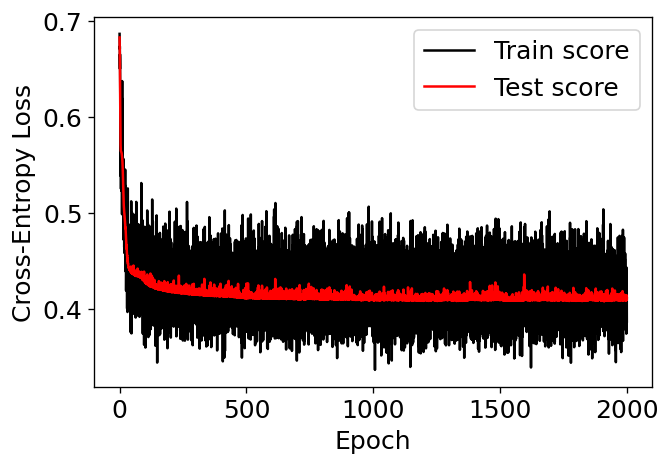

250 0.8994307400379506 0.6463302927369184
500 0.8975332068311196 0.6537536735239113
750 0.9013282732447818 0.6289454600969429
1000 0.905123339658444 0.6589252318613793
1250 0.8956356736242884 0.6462348765314301
1500 0.905123339658444 0.6589252318613793
1750 0.905123339658444 0.6489637800083966
---------------------------------------------


100%|██████████| 2000/2000 [01:11<00:00, 27.87it/s]


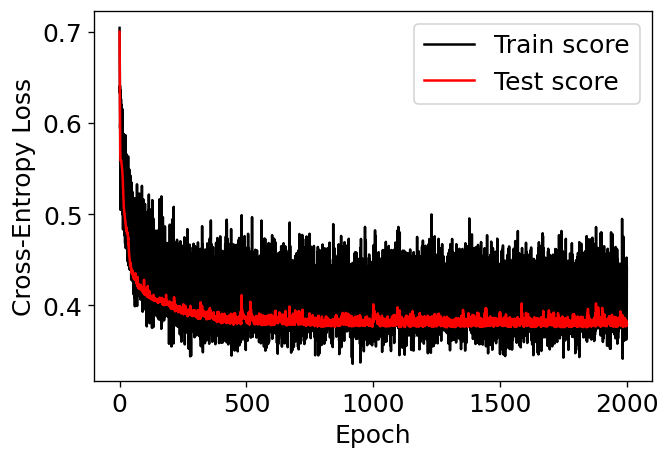

250 0.9259962049335864 0.7466127247051639
500 0.937381404174573 0.761841151101103
750 0.9278937381404174 0.7541315216976452
1000 0.9278937381404174 0.7790351513301018
1250 0.9316888045540797 0.7841112934620815
1500 0.920303605313093 0.6941719781687722
1750 0.9411764705882353 0.7818594710125568
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.45it/s]


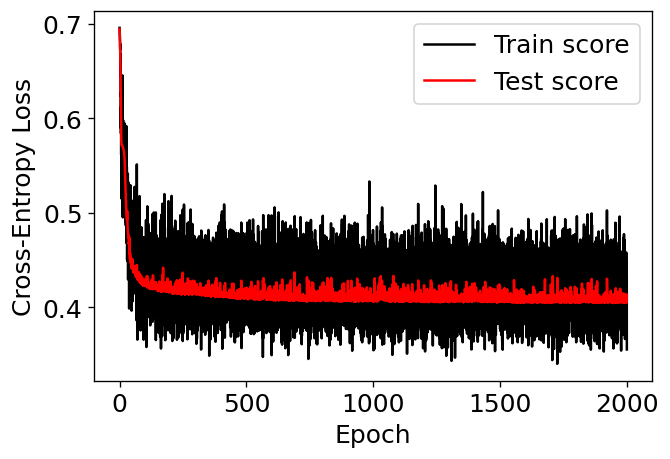

250 0.8975332068311196 0.6392123414670325
500 0.9032258064516129 0.6607950752799823
750 0.9070208728652751 0.6844174145219906
1000 0.9089184060721063 0.6869947341096194
1250 0.9013282732447818 0.676685455759104
1500 0.9032258064516129 0.6700289253133576
1750 0.9032258064516129 0.6792627753467328
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.66it/s]


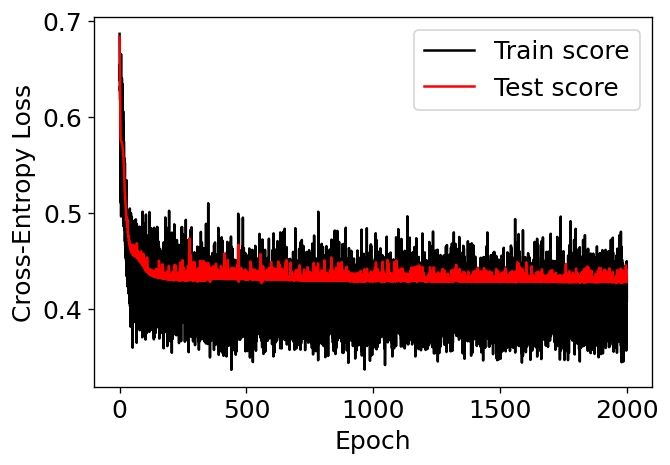

250 0.8652751423149905 0.5794758213362864
500 0.8861480075901328 0.6261351052048727
750 0.8842504743833017 0.628110003691399
1000 0.8861480075901328 0.6306939830195644
1250 0.8918406072106262 0.6293281653746771
1500 0.888045540796964 0.6241602067183463
1750 0.8937381404174574 0.6410299003322258
---------------------------------------------


100%|██████████| 2000/2000 [01:12<00:00, 27.43it/s]


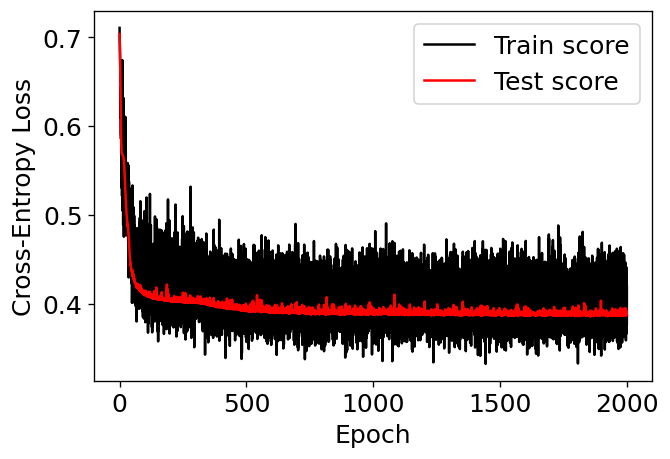

250 0.9070208728652751 0.7326915043105086
500 0.9222011385199241 0.73337510918689
750 0.9222011385199241 0.748129581102123
1000 0.9259962049335864 0.7483004823212184
1250 0.9316888045540797 0.7559340701074779
1500 0.920303605313093 0.7308305799248034
1750 0.9297912713472486 0.7583076981504691
---------------------------------------------
ARCH = VDFCNN_4040_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 95.0+/-7.0710678118654755
TN = 378.8+/-7.0823724838503095
FP = 12.4+/-5.885575587824865
FN = 40.8+/-9.195651146058118
Acc = 0.8990512333965844+/-0.019661227851216136
TSS = 0.668864536911182+/-0.06244365428117725
=>=>=> NUMBER OF EPOCHS: 500
TP = 96.0+/-4.604345773288535
TN = 383.2+/-5.491812087098392
FP = 8.0+/-3.794733192202055
FN = 39.8+/-6.675327707311455
Acc = 0.9092979127134726+/-0.018255807925321745
TSS = 0.6871800228593519+/-0.051474728423262284
=>=>=> NUMBER OF EPOCHS: 750
TP = 96.6+/-7.002856560004638
TN = 382.2+/-5.741080037762929
FP = 9.0+/-3.3466401061363023
FN = 39.2+/-7.88416

In [14]:
# NETWORK: VDFCNN_4040_CNN2_CONN1
ARCH = 'VDFCNN_4040_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:11<00:00, 28.04it/s]


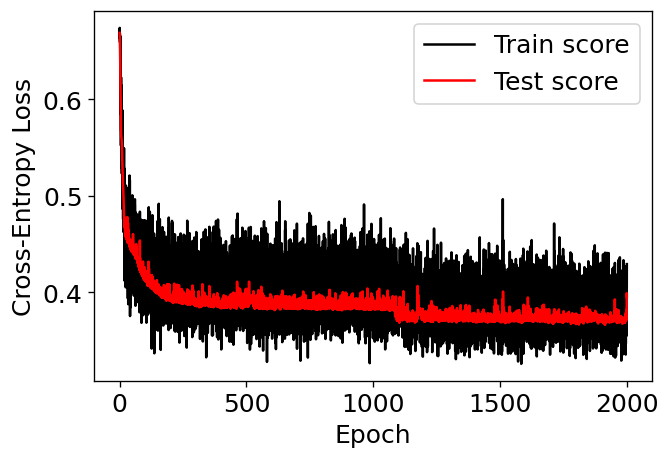

250 0.9259962049335864 0.7565741765581466
500 0.9146110056925996 0.7413457501622075
750 0.9240986717267552 0.7590168314186482
1000 0.9259962049335864 0.761554902484638
1250 0.9354838709677419 0.7941681615205527
1500 0.9392789373814042 0.7843021258730583
1750 0.9449715370018975 0.8118392427769932
---------------------------------------------


100%|██████████| 2000/2000 [01:07<00:00, 29.82it/s]


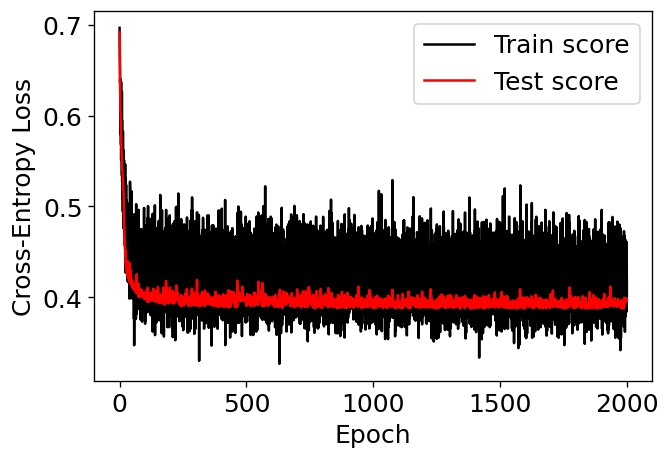

250 0.9127134724857685 0.6790389679783214
500 0.9240986717267552 0.6992481203007519
750 0.9070208728652751 0.6614633029273691
1000 0.9259962049335864 0.706766917293233
1250 0.9222011385199241 0.6917293233082706
1500 0.9184060721062619 0.7165375367352391
1750 0.9222011385199241 0.7216136788672187
---------------------------------------------


100%|██████████| 2000/2000 [01:08<00:00, 29.40it/s]


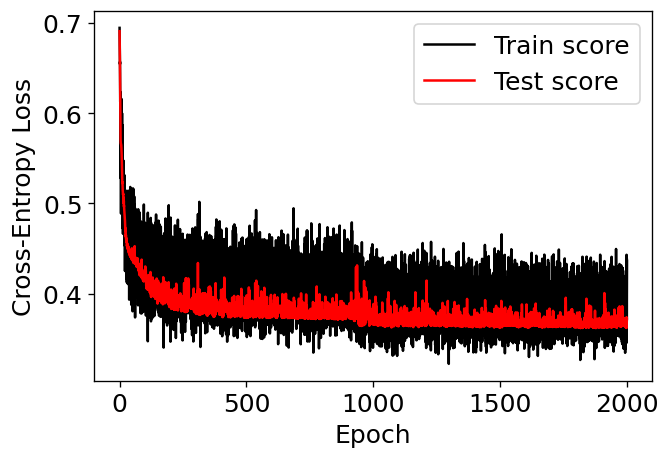

250 0.9354838709677419 0.7877141585700511
500 0.9430740037950665 0.8118742119706297
750 0.9411764705882353 0.8092968923830007
1000 0.9430740037950665 0.793406511903879
1250 0.952561669829222 0.8386115849588371
1500 0.9582542694497154 0.855577393755099
1750 0.9506641366223909 0.8452681154045835
---------------------------------------------


100%|██████████| 2000/2000 [01:09<00:00, 28.67it/s]


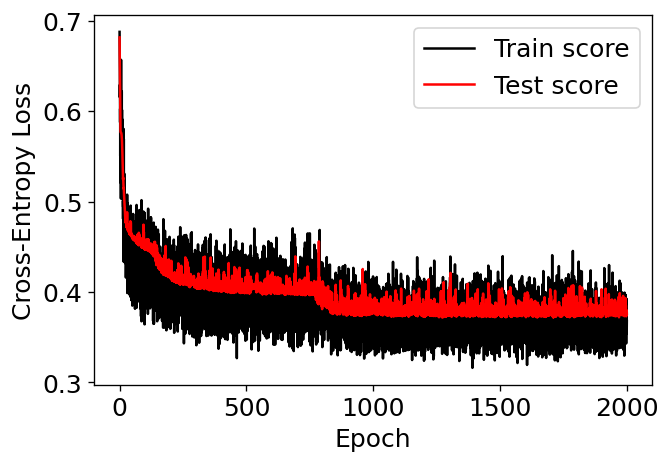

250 0.9108159392789373 0.709874492432632
500 0.9184060721062619 0.7156515319306017
750 0.9184060721062619 0.7156515319306017
1000 0.9354838709677419 0.8027316352897749
1250 0.9430740037950665 0.8313030638612033
1500 0.9316888045540797 0.8066814322628276
1750 0.937381404174573 0.8007567368032484
---------------------------------------------


100%|██████████| 2000/2000 [01:08<00:00, 29.29it/s]


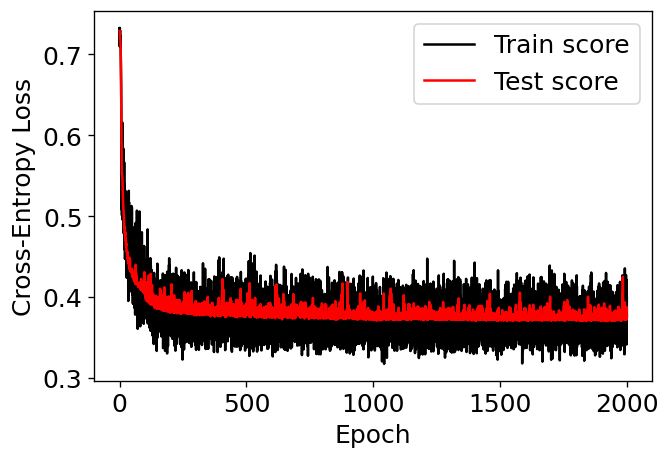

250 0.9354838709677419 0.8003683870722722
500 0.9430740037950665 0.815464661425696
750 0.9411764705882353 0.8178382894686871
1000 0.9392789373814042 0.8054574455964452
1250 0.9316888045540797 0.8100338004633322
1500 0.9411764705882353 0.8030838175534541
1750 0.9411764705882353 0.8129201321636094
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 104.4+/-7.172168430816443
TN = 382.6+/-3.9293765408777004
FP = 8.6+/-2.244994432064365
FN = 31.4+/-6.6211781428987395
Acc = 0.9240986717267552+/-0.010666769884292358
TSS = 0.7467140365222847+/-0.04603061723149732
=>=>=> NUMBER OF EPOCHS: 500
TP = 105.2+/-7.782030583337487
TN = 384.2+/-5.381449618829484
FP = 7.0+/-5.215361924162119
FN = 30.6+/-7.255342858886822
Acc = 0.92865275142315+/-0.012156066321098292
TSS = 0.7567168551579774+/-0.04841265511925068
=>=>=> NUMBER OF EPOCHS: 750
TP = 105.0+/-8.921883209278185
TN = 383.2+/-2.4819347291981715
FP = 8.0+/-2.6076809620810595
FN = 30.8+/-8.3

In [15]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:11<00:00, 27.84it/s]


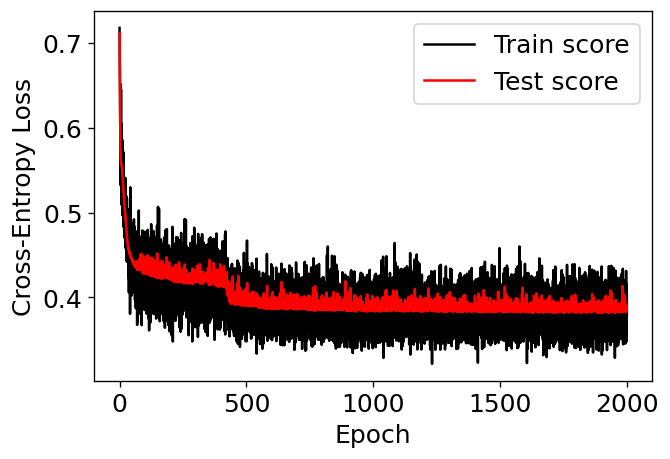

250 0.8937381404174574 0.6486775313919316
500 0.9297912713472486 0.7666310446166177
750 0.9165085388994307 0.7638067249341628
1000 0.920303605313093 0.748959963360177
1250 0.9240986717267552 0.7540361054921567
1500 0.9335863377609108 0.7766879126750887
1750 0.9411764705882353 0.7968016487920307
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 29.93it/s]


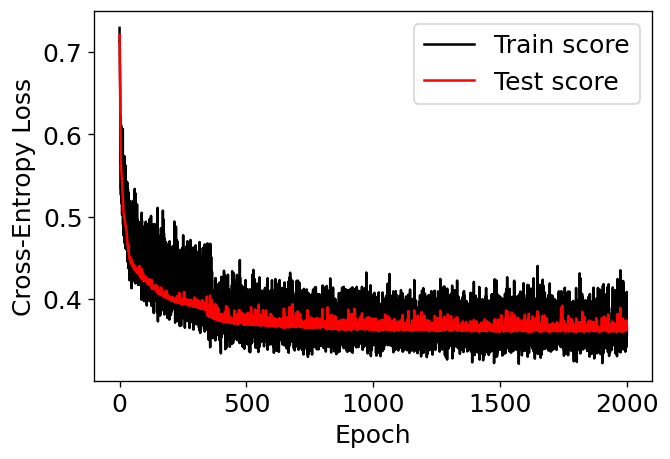

250 0.920303605313093 0.7688828670661425
500 0.9411764705882353 0.8217052784244876
750 0.9487666034155597 0.8418190145414297
1000 0.9468690702087287 0.8592038471814053
1250 0.9582542694497154 0.8545093698713789
1500 0.952561669829222 0.8319529788939353
1750 0.9563567362428842 0.8519712988053891
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.70it/s]


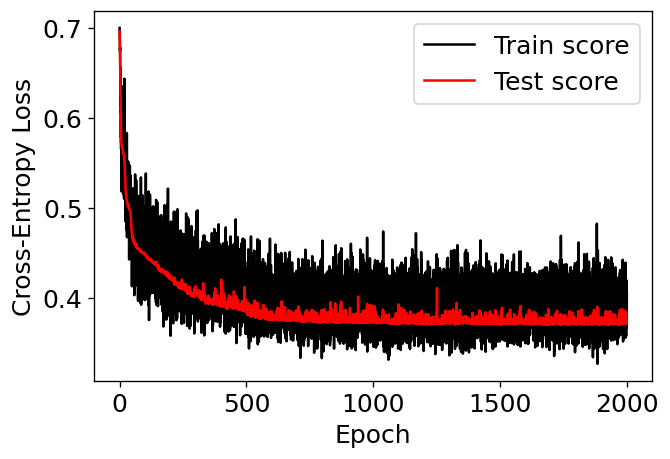

250 0.9032258064516129 0.7300489505302974
500 0.937381404174573 0.776440703107617
750 0.9544592030360531 0.8458058295631536
1000 0.9468690702087287 0.8124119261291998
1250 0.9354838709677419 0.7692464585033005
1500 0.9487666034155597 0.838073870800267
1750 0.9468690702087287 0.8354965512126381
---------------------------------------------


100%|██████████| 2000/2000 [01:06<00:00, 30.22it/s]


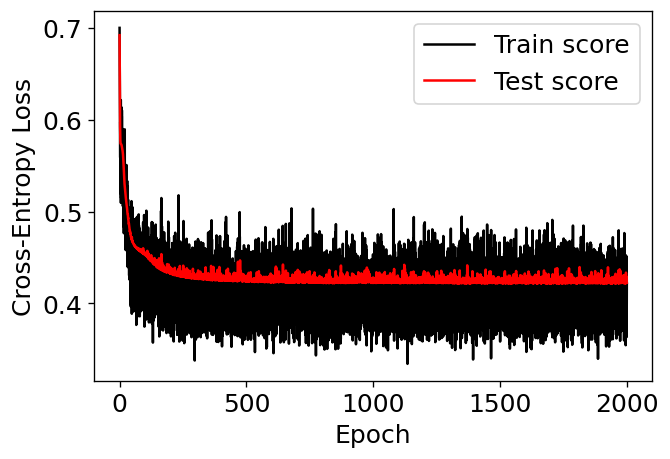

250 0.888045540796964 0.5922480620155038
500 0.8994307400379506 0.648781838316722
750 0.889943074003795 0.599390919158361
1000 0.8975332068311196 0.6461978589885566
1250 0.889943074003795 0.6358619416758952
1500 0.8861480075901328 0.5896640826873385
1750 0.9013282732447818 0.6513658176448874
---------------------------------------------


100%|██████████| 2000/2000 [01:05<00:00, 30.42it/s]


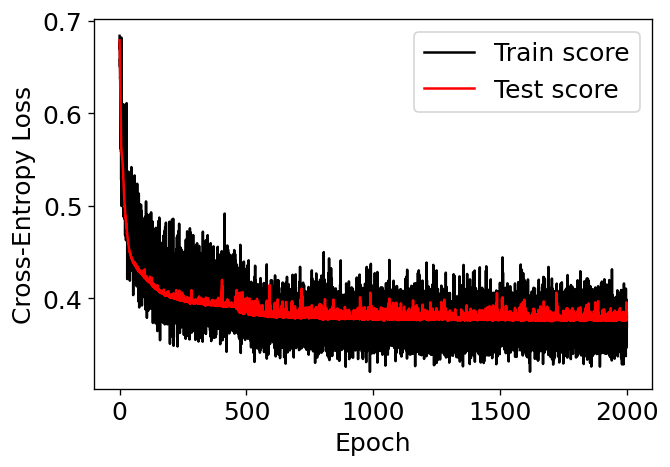

250 0.9222011385199241 0.7284569518818124
500 0.9127134724857685 0.7599977213170788
750 0.9240986717267552 0.7998556834149861
1000 0.937381404174573 0.8029129163343587
1250 0.9354838709677419 0.7856139151570393
1500 0.9411764705882353 0.8030838175534541
1750 0.9411764705882353 0.7981656602483764
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 98.4+/-9.687104830649869
TN = 378.8+/-6.675327707311454
FP = 12.4+/-6.560487786742691
FN = 37.4+/-10.836973747315252
Acc = 0.9055028462998103+/-0.013756788584737646
TSS = 0.6936628725771377+/-0.06403322093601226
=>=>=> NUMBER OF EPOCHS: 500
TP = 105.8+/-6.881860213634101
TN = 381.2+/-4.833218389437829
FP = 10.0+/-6.131883886702357
FN = 30.0+/-9.143303560529969
Acc = 0.9240986717267553+/-0.015739234423778156
TSS = 0.7547113171565046+/-0.0571864276190228
=>=>=> NUMBER OF EPOCHS: 750
TP = 108.2+/-12.12270596855339
TN = 380.2+/-5.114684741017769
FP = 11.0+/-7.238784428341543
FN = 27.6+/-13.

In [16]:
# NETWORK: VDFCNN_4040_CNN1_CONN1
ARCH = 'VDFCNN_4040_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_4040_CNN1_CONN2 with 1750 epochs

Running for the best configuration now...

100%|██████████| 1750/1750 [01:01<00:00, 28.41it/s]


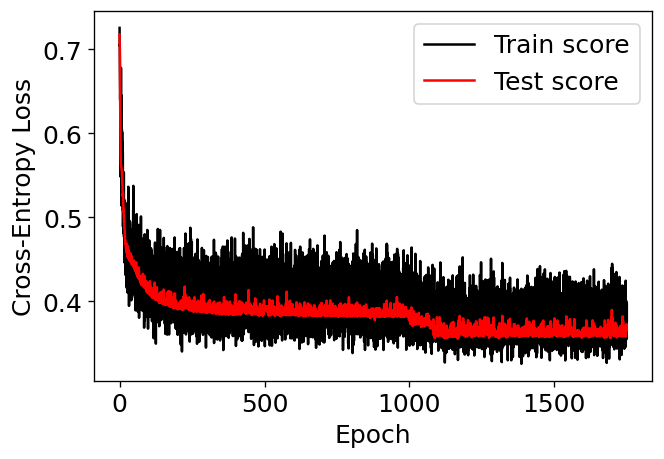

0.9468690702087287 -1
0.9468690702087287 0.8143773138429831
---------------------------------------------


100%|██████████| 1750/1750 [01:00<00:00, 29.12it/s]


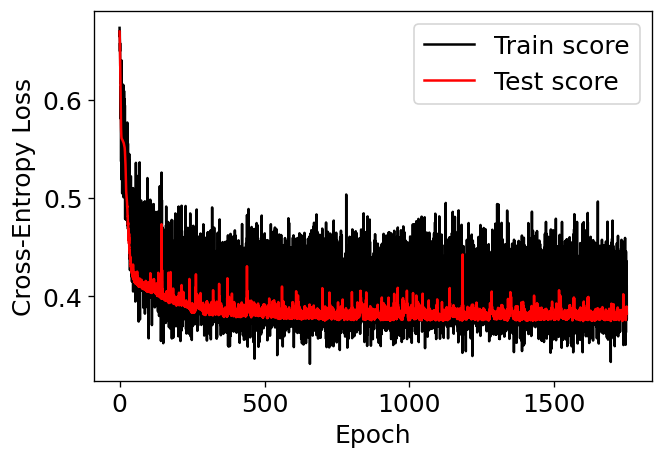

0.9297912713472486 -1
0.9297912713472486 0.7616503186901263
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.69it/s]


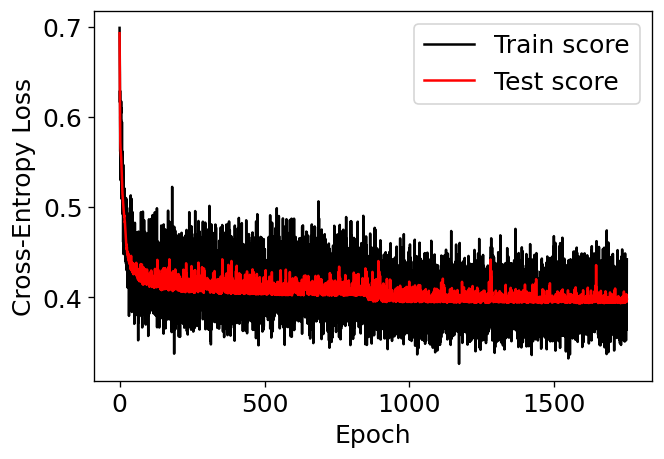

0.9165085388994307 -1
0.9165085388994307 0.7203886375435733
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.25it/s]


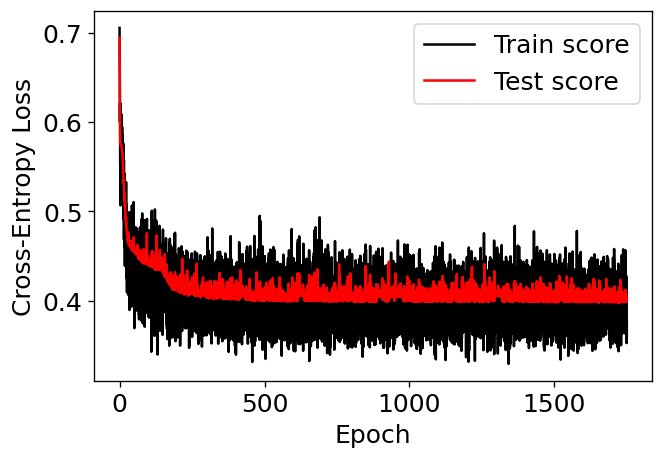

0.9165085388994307 -1
0.9165085388994307 0.7221853082318199
---------------------------------------------


100%|██████████| 1750/1750 [01:00<00:00, 28.87it/s]


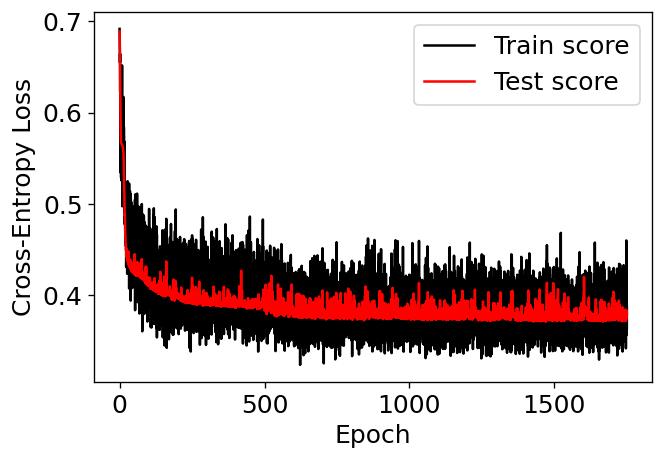

0.937381404174573 -1
0.937381404174573 0.7783221298089704
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.57it/s]


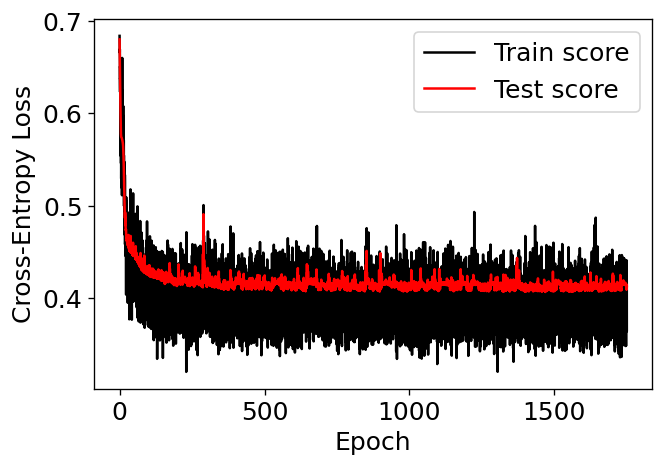

0.8975332068311196 -1
0.8975332068311196 0.6576800415337832
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.34it/s]


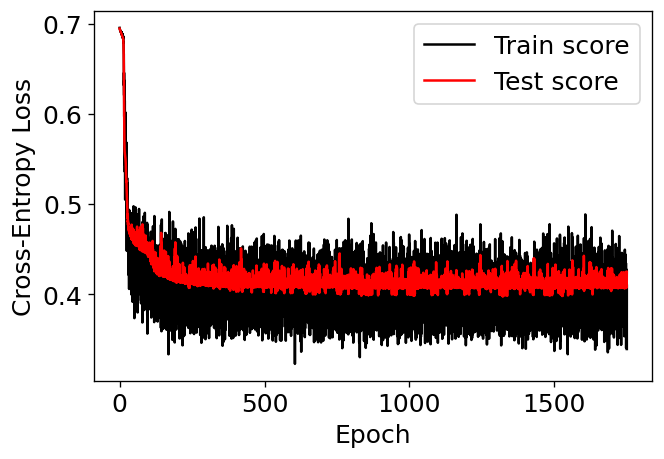

0.8823529411764706 -1
0.8823529411764706 0.6472389071885294
---------------------------------------------


100%|██████████| 1750/1750 [01:00<00:00, 28.74it/s]


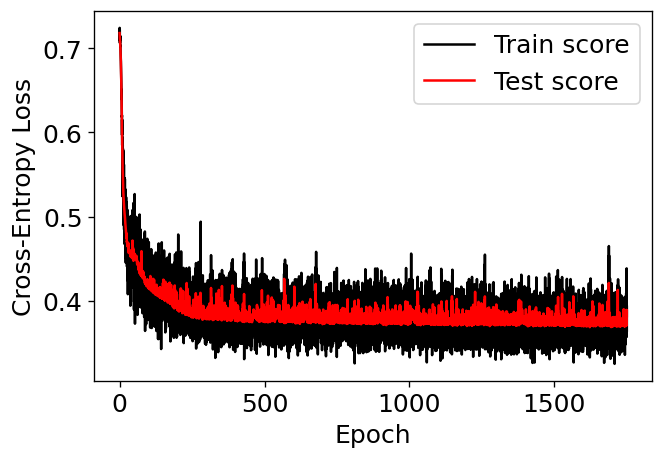

0.9411764705882353 -1
0.9411764705882353 0.8369984424831269
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.47it/s]


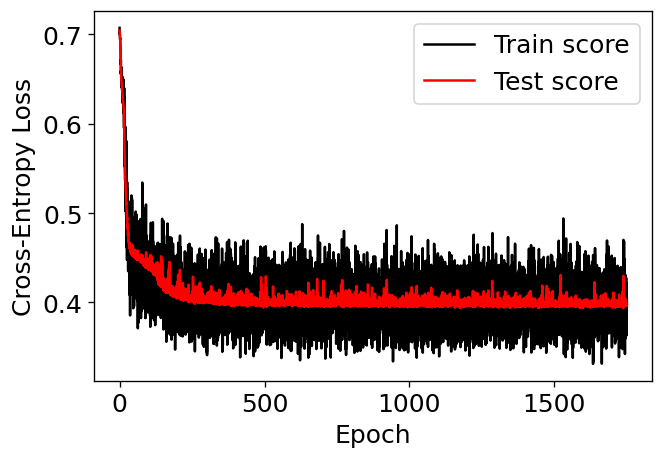

0.9184060721062619 -1
0.9184060721062619 0.682384792177944
---------------------------------------------


100%|██████████| 1750/1750 [01:01<00:00, 28.50it/s]


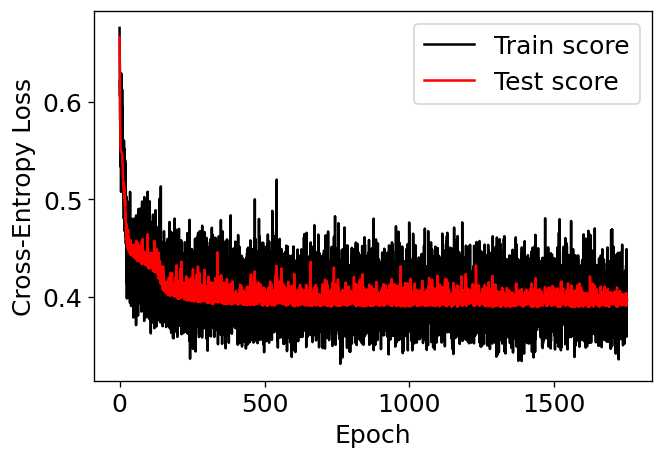

0.920303605313093 -1
0.920303605313093 0.7122834645669291
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
TP = 101.7+/-9.209234495874236
TN = 383.5+/-7.116881339463234
FP = 9.2+/-5.6000000000000005
FN = 32.6+/-7.605261336732618
Acc = 0.9206831119544592+/-0.01874240337740531
TSS = 0.7333509356067786+/-0.06050354304379169


In [17]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + st+r(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Best architecture for 60x60 VDFs (5-fold CV for faster assessment)

In [11]:
class VDFCNN_6060_CNN3_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN3_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN3_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(16*7*7+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 16 * 7 * 7)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN2_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN2_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(4, 8, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(8*15*15+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 8 * 15 * 15)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN2(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN2, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+12, 50),
        nn.ReLU(True),
        nn.Linear(50, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x


class VDFCNN_6060_CNN1_CONN1(nn.Module):
  def __init__(self):
    super(VDFCNN_6060_CNN1_CONN1, self).__init__()
    self.cnncell = nn.Sequential(
        nn.Conv2d(2, 4, kernel_size=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.linearcell = nn.Sequential(
        nn.Linear(4*30*30+12, 10),
        nn.ReLU(True),
        nn.Linear(10,2),
        nn.Sigmoid()
    )
  def forward(self, x):
    x_cnn = x[:, :-12]
    x_p = x[:, -12:]
    x_cnn = x_cnn.reshape(-1, 2, 60, 60)
    x_cnn = self.cnncell(x_cnn)
    x_cnn = x_cnn.view(-1, 4 * 30 * 30)
    x = torch.cat((x_cnn, x_p), dim=1)
    x = self.linearcell(x)
    return x

100%|██████████| 2000/2000 [02:14<00:00, 14.89it/s]


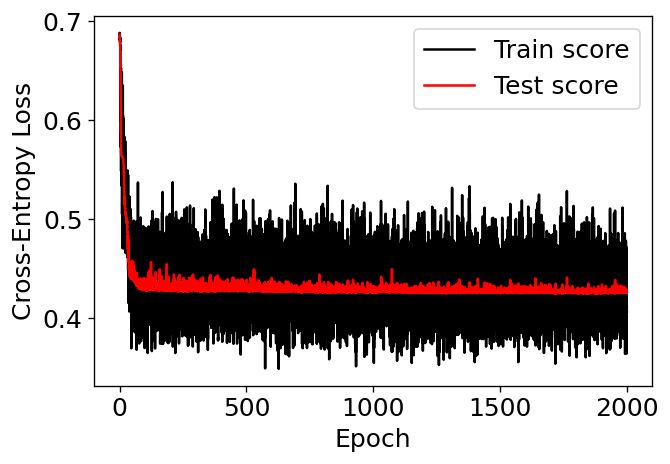

250 0.8861480075901328 0.6285637952749895
500 0.8785578747628083 0.6233922369375214
750 0.8861480075901328 0.623583069348498
1000 0.888045540796964 0.6360825922674707
1250 0.888045540796964 0.626121140414488
1500 0.8842504743833017 0.6359871760619824
1750 0.889943074003795 0.6386206633334606
---------------------------------------------


100%|██████████| 2000/2000 [02:14<00:00, 14.90it/s]


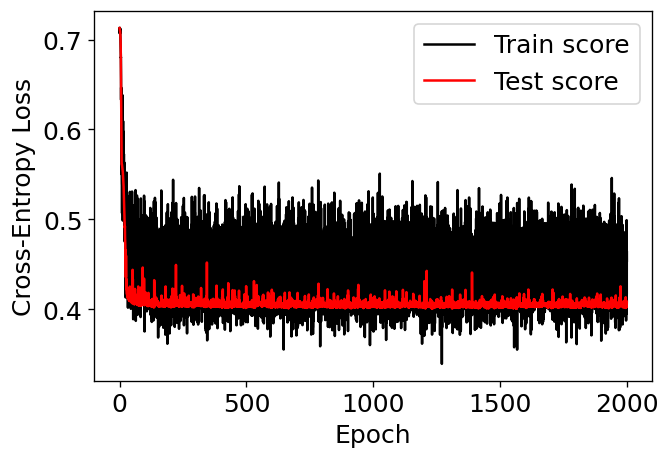

250 0.9070208728652751 0.686366932559826
500 0.9127134724857685 0.6790389679783214
750 0.9089184060721063 0.6938857295523071
1000 0.905123339658444 0.6788481355673447
1250 0.9013282732447818 0.6837334452883477
1500 0.9089184060721063 0.6938857295523071
1750 0.9070208728652751 0.686366932559826
---------------------------------------------


100%|██████████| 2000/2000 [02:14<00:00, 14.84it/s]


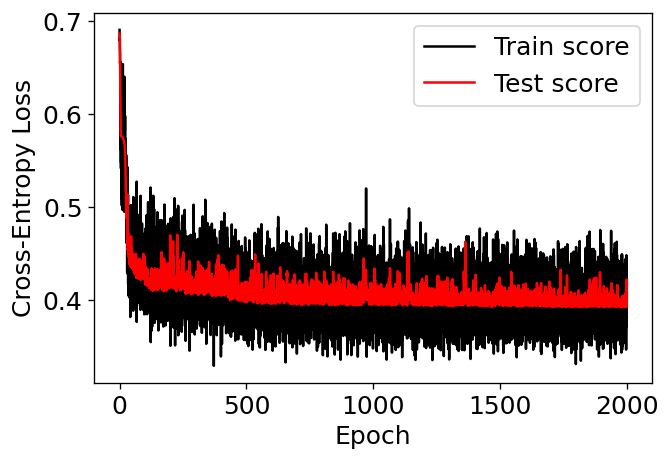

250 0.8747628083491461 0.6406029815322999
500 0.9089184060721063 0.6962285841429948
750 0.9146110056925996 0.6901097678558185
1000 0.9127134724857685 0.682915523251502
1250 0.920303605313093 0.7116925016687681
1500 0.9108159392789373 0.6711043536304977
1750 0.9240986717267552 0.7260809908774012
---------------------------------------------


100%|██████████| 2000/2000 [02:14<00:00, 14.89it/s]


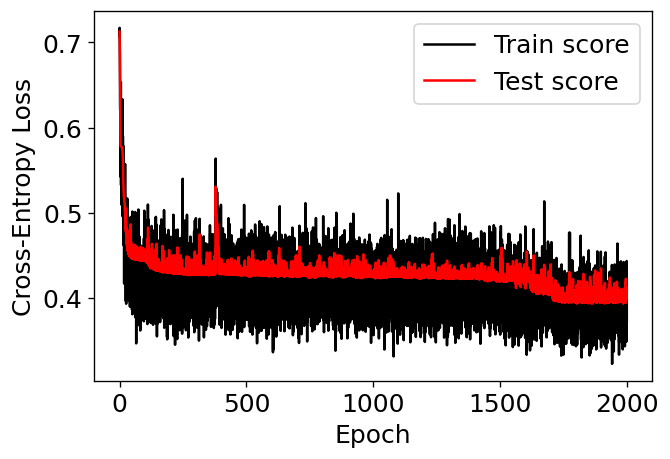

250 0.888045540796964 0.6150424510889627
500 0.8823529411764706 0.5936138796603914
750 0.8842504743833017 0.5870801033591732
1000 0.889943074003795 0.62218530823182
1250 0.8918406072106262 0.6293281653746771
1500 0.8937381404174574 0.6273532668881506
1750 0.9089184060721063 0.6753783684016242
---------------------------------------------


100%|██████████| 2000/2000 [02:12<00:00, 15.12it/s]


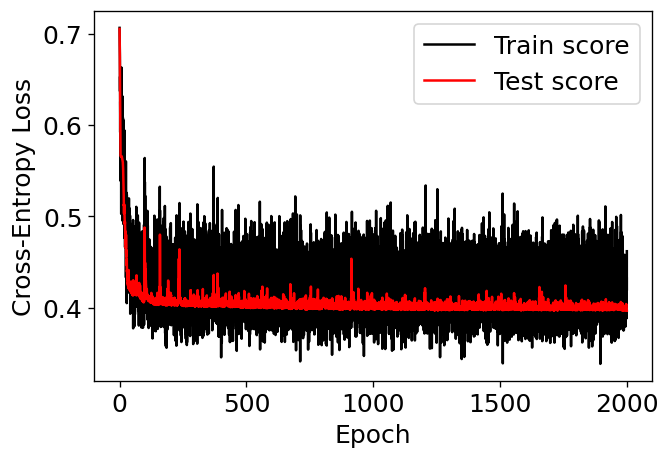

250 0.9070208728652751 0.6736736166495766
500 0.9089184060721063 0.6712999886065854
750 0.9127134724857685 0.6763890471307584
1000 0.9127134724857685 0.6763890471307584
1250 0.9127134724857685 0.6763890471307584
1500 0.9108159392789373 0.6689263605635942
1750 0.9127134724857685 0.6763890471307584
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 92.8+/-3.4871191548325386
TN = 377.6+/-7.735631842325486
FP = 13.6+/-6.406246951218787
FN = 43.0+/-4.427188724235731
Acc = 0.8925996204933586+/-0.012621092332687572
TSS = 0.6488499554211309+/-0.027004540178931138
=>=>=> NUMBER OF EPOCHS: 500
TP = 92.0+/-4.560701700396552
TN = 381.4+/-5.851495535331117
FP = 9.8+/-5.775811631277461
FN = 43.8+/-5.268775948927796
Acc = 0.8982922201138519+/-0.014678618296632818
TSS = 0.6527147314651629+/-0.03816949555667377
=>=>=> NUMBER OF EPOCHS: 750
TP = 91.4+/-4.882622246293481
TN = 383.6+/-3.32264954516723
FP = 7.6+/-4.6303347611160905
FN = 44.4+/-6.34

In [19]:
# NETWORK: VDFCNN_6060_CNN3_CONN2
ARCH = 'VDFCNN_6060_CNN3_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:12<00:00, 15.07it/s]


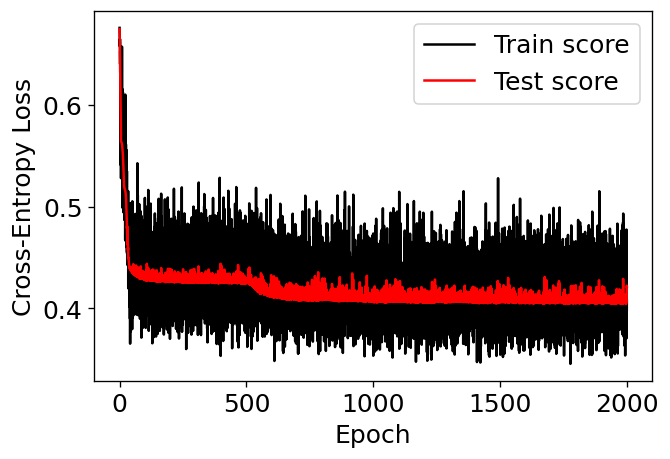

250 0.8709677419354839 0.6182206786000535
500 0.8804554079696395 0.6259303080035112
750 0.9089184060721063 0.6590206480668677
1000 0.9089184060721063 0.664001373993359
1250 0.8975332068311196 0.6487729475974199
1500 0.9070208728652751 0.6564825770008779
1750 0.8994307400379506 0.6513110186634098
---------------------------------------------


100%|██████████| 2000/2000 [02:13<00:00, 15.00it/s]


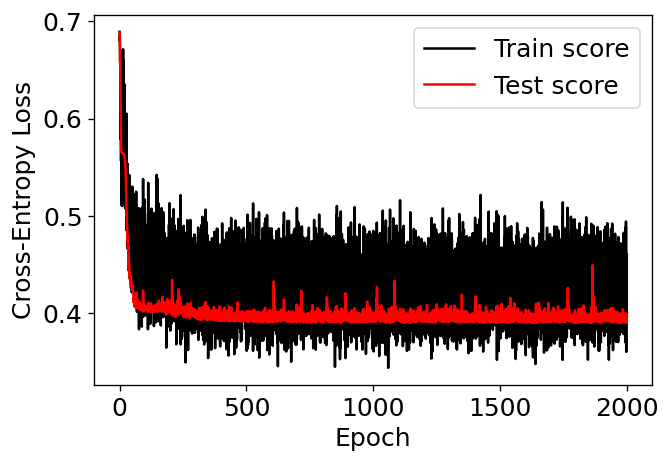

250 0.9146110056925996 0.6965192168237854
500 0.9146110056925996 0.6965192168237854
750 0.9146110056925996 0.6965192168237854
1000 0.9240986717267552 0.6992481203007519
1250 0.920303605313093 0.6891912522422808
1500 0.9184060721062619 0.7015953589557651
1750 0.9127134724857685 0.6939811457577956
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.16it/s]


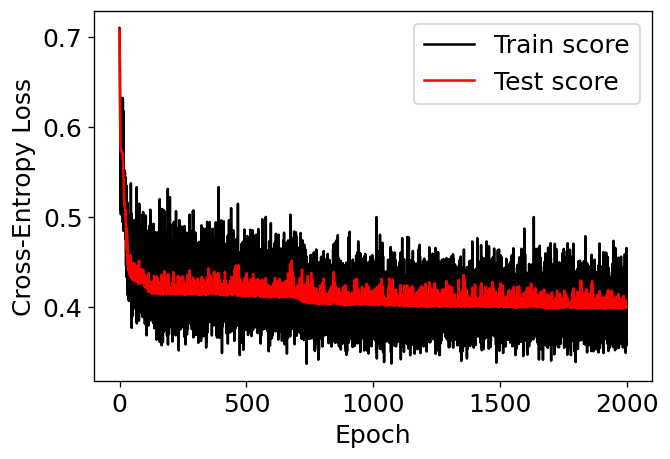

250 0.9032258064516129 0.6607950752799823
500 0.8975332068311196 0.6392123414670325
750 0.9127134724857685 0.7013832233182525
1000 0.9127134724857685 0.7013832233182525
1250 0.9108159392789373 0.694188978713936
1500 0.9089184060721063 0.6869947341096194
1750 0.9089184060721063 0.6869947341096194
---------------------------------------------


100%|██████████| 2000/2000 [02:16<00:00, 14.62it/s]


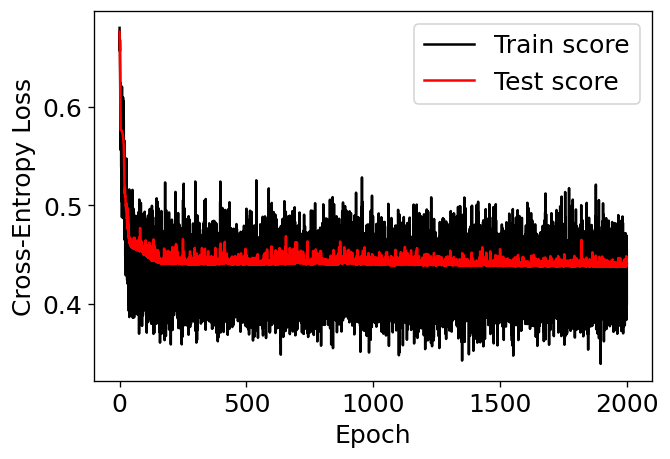

RERUNNING THE SAMPLE...


100%|██████████| 2000/2000 [02:14<00:00, 14.91it/s]


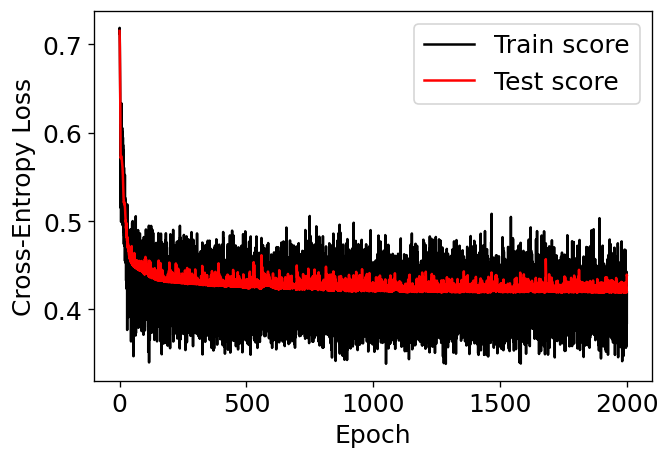

250 0.8918406072106262 0.6293281653746771
500 0.8766603415559773 0.608656330749354
750 0.888045540796964 0.6241602067183463
1000 0.8956356736242884 0.6344961240310077
1250 0.8975332068311196 0.6325212255444814
1500 0.8937381404174574 0.6273532668881506
1750 0.8956356736242884 0.6253783684016242
---------------------------------------------


100%|██████████| 2000/2000 [02:11<00:00, 15.21it/s]


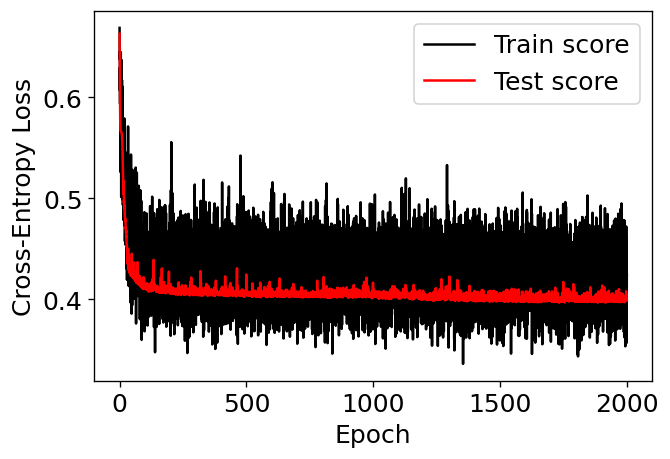

250 0.9070208728652751 0.6736736166495766
500 0.905123339658444 0.6908017166078007
750 0.9165085388994307 0.701150734875242
1000 0.9032258064516129 0.6882571873457142
1250 0.9108159392789373 0.6689263605635942
1500 0.9165085388994307 0.6962325775701645
1750 0.905123339658444 0.6760472446925677
---------------------------------------------
ARCH = VDFCNN_6060_CNN3_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 92.8+/-1.5999999999999999
TN = 380.2+/-6.675327707311454
FP = 11.0+/-7.536577472566709
FN = 43.0+/-3.7416573867739413
Acc = 0.8975332068311197+/-0.015180265654648936
TSS = 0.655707350545615+/-0.02868934322578714
=>=>=> NUMBER OF EPOCHS: 500
TP = 92.8+/-2.7129319932501073
TN = 378.8+/-5.706137047074842
FP = 12.4+/-5.314132102234569
FN = 43.0+/-4.9396356140913875
Acc = 0.894876660341556+/-0.014431235933078943
TSS = 0.6522239827302967+/-0.03523949418665056
=>=>=> NUMBER OF EPOCHS: 750
TP = 94.2+/-3.8678159211627436
TN = 384.4+/-4.715930449020639
FP = 6.8+/-1.9390719429665317
FN = 41.6+/-4.31

In [20]:
# NETWORK: VDFCNN_6060_CNN3_CONN1
ARCH = 'VDFCNN_6060_CNN3_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN3_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:01<00:00, 16.43it/s]


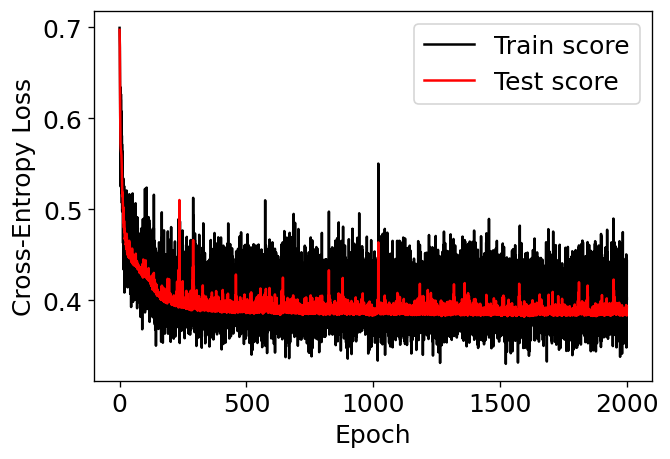

250 0.9108159392789373 0.696423800618297
500 0.9297912713472486 0.7467081409106523
750 0.9240986717267552 0.7390939277126828
1000 0.9297912713472486 0.7467081409106523
1250 0.9259962049335864 0.7316705469256899
1500 0.9297912713472486 0.7516888668371435
1750 0.9240986717267552 0.744074653639174
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.29it/s]


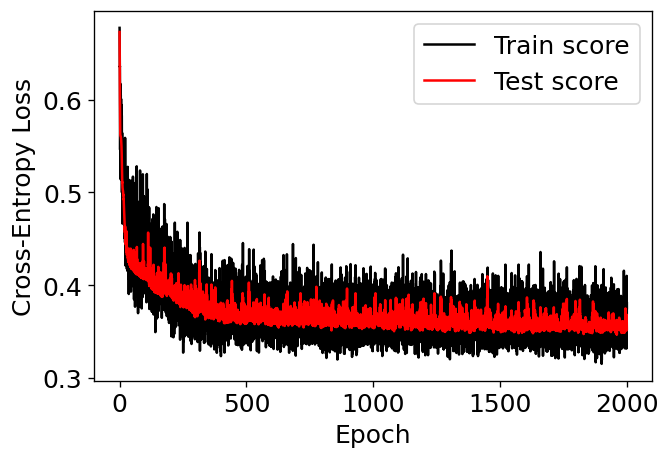

250 0.9392789373814042 0.7992443036525324
500 0.9411764705882353 0.841628182130453
750 0.9506641366223909 0.864279989313385
1000 0.9563567362428842 0.8519712988053891
1250 0.9620493358633776 0.86456623792985
1500 0.9563567362428842 0.837029121025915
1750 0.9544592030360531 0.8494332277393992
---------------------------------------------


100%|██████████| 2000/2000 [02:04<00:00, 16.03it/s]


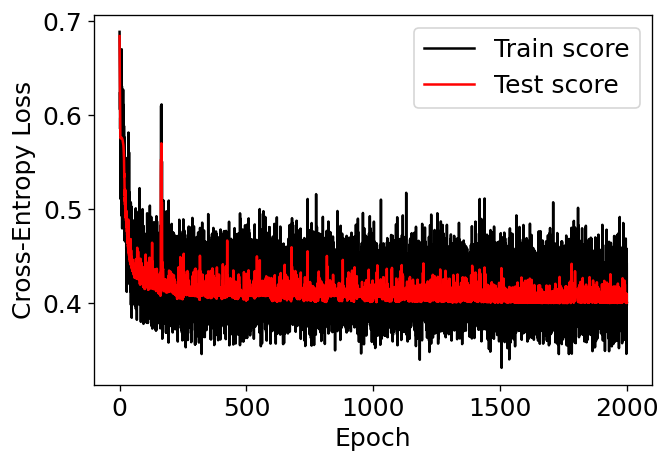

250 0.8785578747628083 0.64114069569087
500 0.8994307400379506 0.6787250611881629
750 0.9089184060721063 0.6777608840762442
1000 0.9070208728652751 0.6798004895053029
1250 0.9108159392789373 0.6849551286805607
1500 0.9089184060721063 0.6869947341096194
1750 0.9165085388994307 0.697304012460135
---------------------------------------------


100%|██████████| 2000/2000 [02:04<00:00, 16.01it/s]


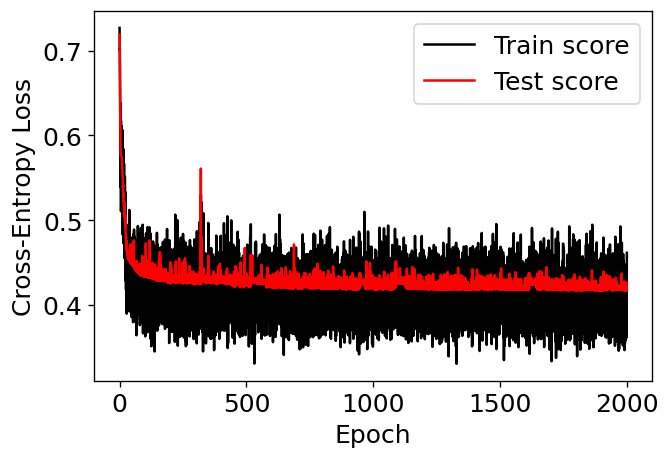

250 0.889943074003795 0.62218530823182
500 0.8747628083491461 0.5422480620155039
750 0.8842504743833017 0.6189922480620156
1000 0.888045540796964 0.6241602067183463
1250 0.8956356736242884 0.6344961240310077
1500 0.8994307400379506 0.6396640826873385
1750 0.8861480075901328 0.6215762273901809
---------------------------------------------


100%|██████████| 2000/2000 [02:05<00:00, 15.89it/s]


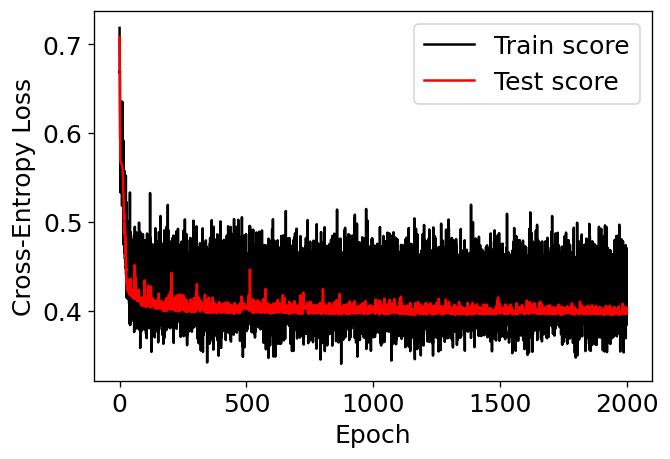

250 0.9032258064516129 0.6587482435152482
500 0.9070208728652751 0.6736736166495766
750 0.9127134724857685 0.6813072044358361
1000 0.9146110056925996 0.6986062056131556
1250 0.9108159392789373 0.6689263605635942
1500 0.9032258064516129 0.6390756142949375
1750 0.9184060721062619 0.7086134214424062
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 96.6+/-6.770524351924302
TN = 380.0+/-7.402702209328699
FP = 11.2+/-5.455272678794342
FN = 39.2+/-8.657944328765346
Acc = 0.9043643263757115+/-0.02066830938017475
TSS = 0.6835484703417535+/-0.06281752660018036
=>=>=> NUMBER OF EPOCHS: 500
TP = 97.4+/-12.92439553712281
TN = 382.4+/-4.882622246293481
FP = 8.8+/-4.578209256903839
FN = 38.4+/-15.21315220458929
Acc = 0.9104364326375712+/-0.023345057304333512
TSS = 0.6965966125788698+/-0.09819740586272098
=>=>=> NUMBER OF EPOCHS: 750
TP = 100.0+/-10.079682534683322
TN = 382.8+/-4.445222154178573
FP = 8.4+/-3.1368774282716245
FN = 35.8+/-12.1

In [21]:
# NETWORK: VDFCNN_6060_CNN2_CONN2
ARCH = 'VDFCNN_6060_CNN2_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [02:03<00:00, 16.15it/s]


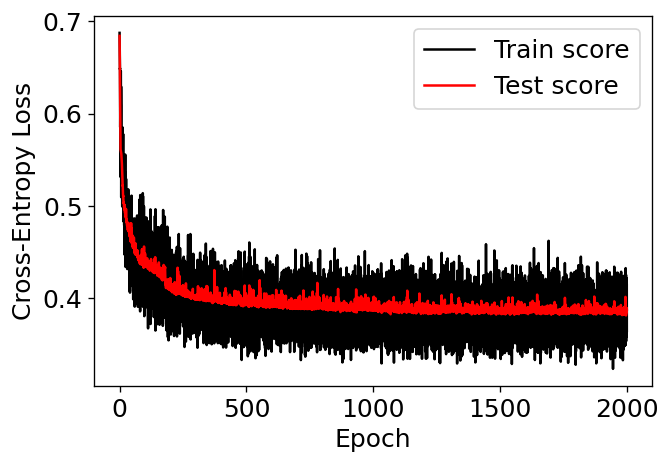

250 0.905123339658444 0.7485782985382237
500 0.9165085388994307 0.778748902713637
750 0.9240986717267552 0.7839204610511049
1000 0.9184060721062619 0.7464218922941872
1250 0.9259962049335864 0.7964199839700774
1500 0.9316888045540797 0.7990534712415557
1750 0.9297912713472486 0.8114575779550398
---------------------------------------------


100%|██████████| 2000/2000 [01:58<00:00, 16.85it/s]


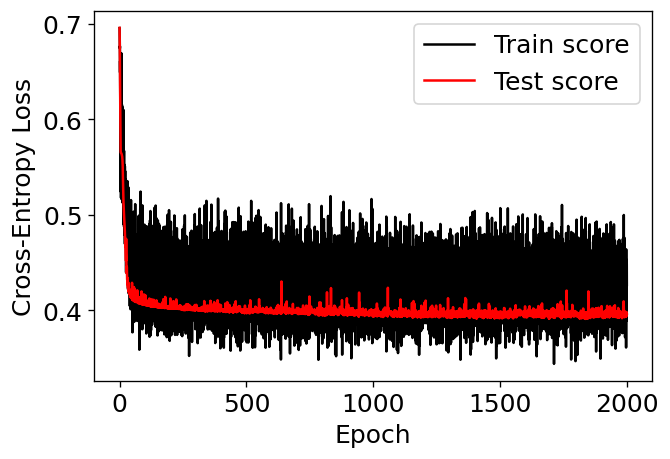

250 0.9127134724857685 0.6840196939048128
500 0.920303605313093 0.7041334300217549
750 0.9146110056925996 0.6965192168237854
1000 0.9146110056925996 0.7014999427502767
1250 0.9184060721062619 0.6766917293233082
1500 0.920303605313093 0.6842105263157895
1750 0.920303605313093 0.6891912522422808
---------------------------------------------


100%|██████████| 2000/2000 [02:00<00:00, 16.57it/s]


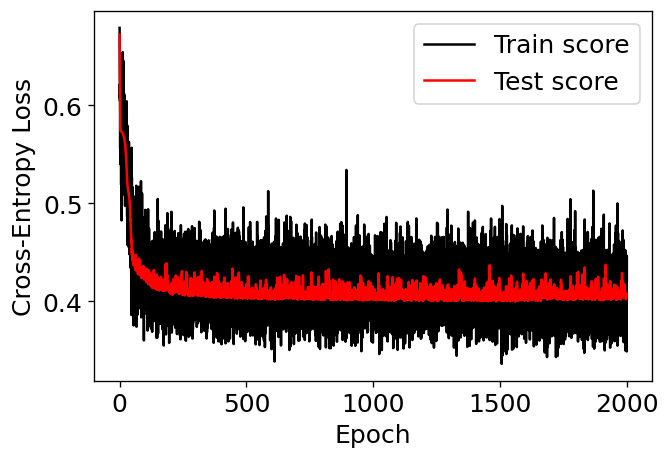

250 0.8918406072106262 0.6545650077875844
500 0.9032258064516129 0.7023474004301713
750 0.8937381404174574 0.6894608024920269
1000 0.8994307400379506 0.6602573611214121
1250 0.9089184060721063 0.7054624341763702
1500 0.8918406072106262 0.6637988578209597
1750 0.9108159392789373 0.7265074538307499
---------------------------------------------


100%|██████████| 2000/2000 [02:06<00:00, 15.84it/s]


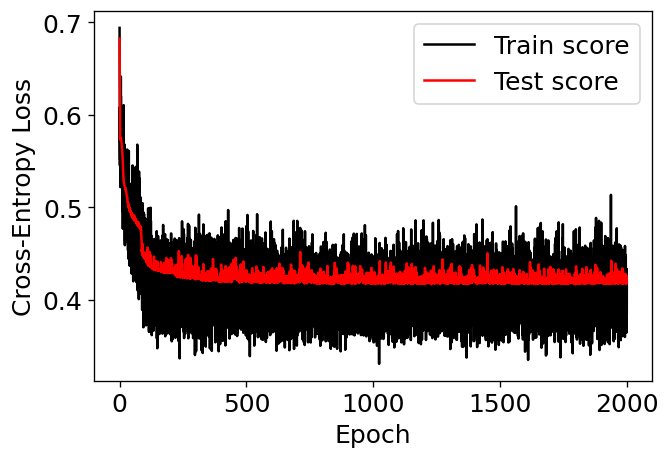

250 0.889943074003795 0.6267441860465116
500 0.8937381404174574 0.6227943890734589
750 0.8918406072106262 0.6384459210040605
1000 0.8918406072106262 0.6293281653746771
1250 0.8937381404174574 0.6364710225175342
1500 0.8785578747628083 0.6203580657069029
1750 0.8994307400379506 0.648781838316722
---------------------------------------------


100%|██████████| 2000/2000 [02:02<00:00, 16.34it/s]


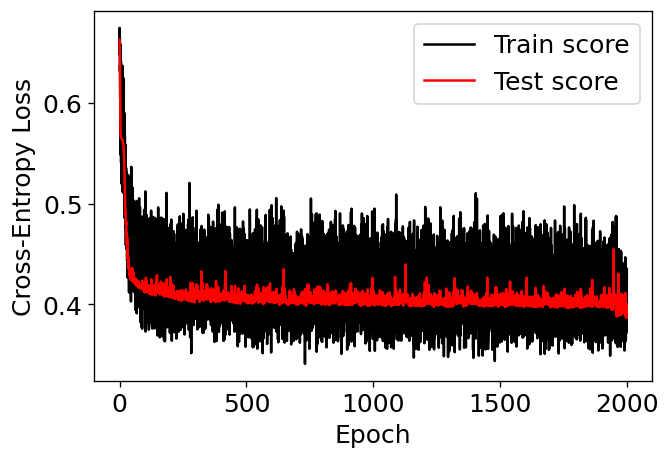

250 0.8994307400379506 0.6831681288215411
500 0.9070208728652751 0.7081007177851203
750 0.9013282732447818 0.695548972693783
1000 0.9070208728652751 0.7130188750901978
1250 0.9108159392789373 0.7181079336143709
1500 0.9070208728652751 0.7130188750901978
1750 0.9165085388994307 0.7257415214006304
---------------------------------------------
ARCH = VDFCNN_6060_CNN2_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 97.0+/-5.89915248150105
TN = 377.2+/-6.241794613730893
FP = 14.0+/-6.54217089351845
FN = 38.8+/-7.95989949685296
Acc = 0.8998102466793169+/-0.00843495664929522
TSS = 0.6794150630197348+/-0.04052304974222892
=>=>=> NUMBER OF EPOCHS: 500
TP = 99.6+/-7.418894796396563
TN = 379.0+/-6.572670690061994
FP = 12.2+/-6.794115100585213
FN = 36.2+/-9.26066952223218
Acc = 0.9081593927893739+/-0.00949525313335619
TSS = 0.7032249680048285+/-0.0493929369548723
=>=>=> NUMBER OF EPOCHS: 750
TP = 100.0+/-6.06630035524124
TN = 377.0+/-6.0332412515993425
FP = 14.2+/-4.874423042781576
FN = 35.8+/-7.678541528

In [22]:
# NETWORK: VDFCNN_6060_CNN2_CONN1
ARCH = 'VDFCNN_6060_CNN2_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN2_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:44<00:00, 19.17it/s]


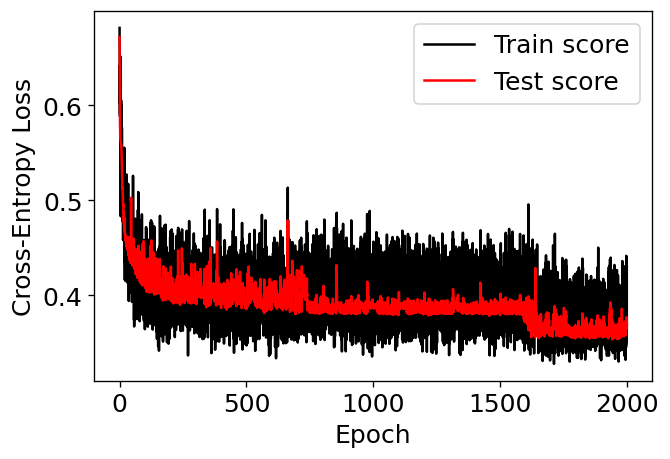

250 0.9070208728652751 0.6515018510743864
500 0.9222011385199241 0.7564787603526583
750 0.9259962049335864 0.7316705469256899
1000 0.9222011385199241 0.7415365825731842
1250 0.9278937381404174 0.7591122476241364
1500 0.9297912713472486 0.756669592763635
1750 0.9506641366223909 0.864279989313385
---------------------------------------------


100%|██████████| 2000/2000 [01:50<00:00, 18.12it/s]


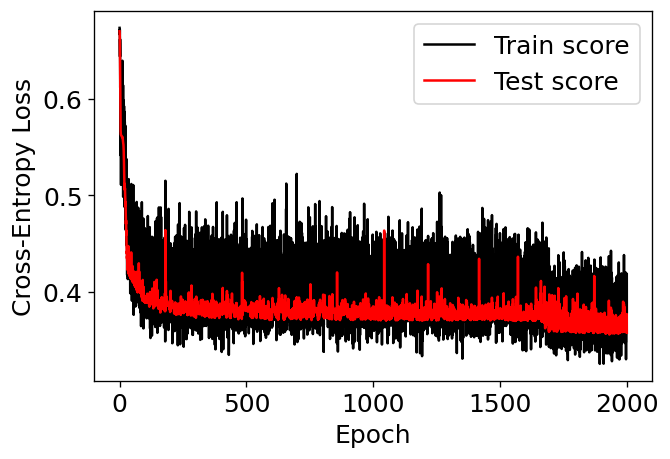

250 0.9278937381404174 0.7541315216976452
500 0.937381404174573 0.7917255066600511
750 0.9297912713472486 0.7666310446166177
1000 0.9392789373814042 0.7693599480935842
1250 0.9449715370018975 0.7919163390710278
1500 0.9411764705882353 0.7768787450860654
1750 0.9544592030360531 0.8494332277393992
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 18.92it/s]


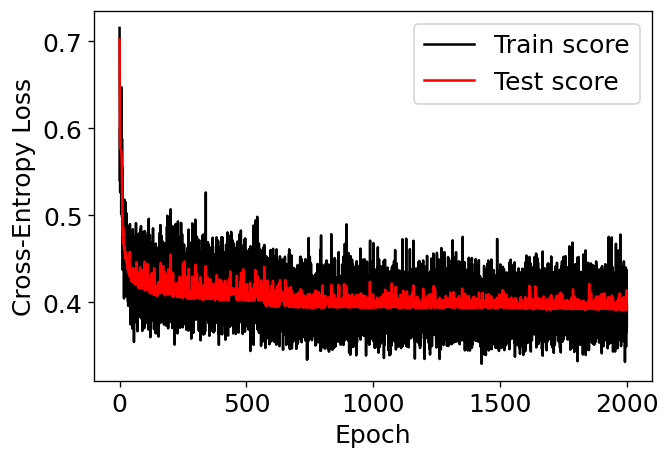

250 0.8671726755218216 0.6395275532151599
500 0.8937381404174574 0.6709931024252763
750 0.905123339658444 0.7049247200178002
1000 0.9108159392789373 0.7080397537639991
1250 0.920303605313093 0.725543276718831
1500 0.9089184060721063 0.7100793591930579
1750 0.9165085388994307 0.7203886375435733
---------------------------------------------


100%|██████████| 2000/2000 [01:48<00:00, 18.42it/s]


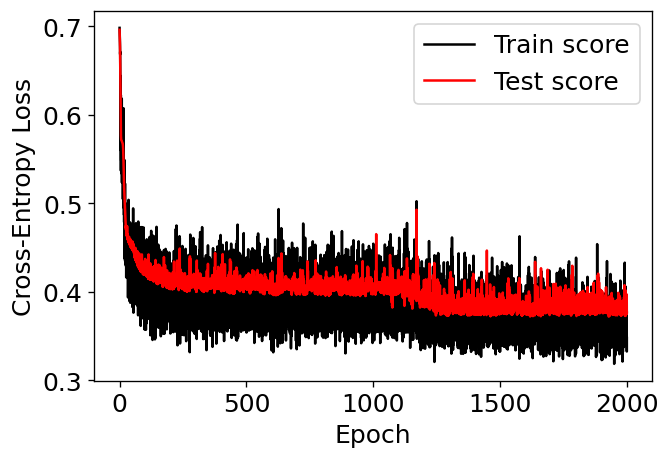

250 0.9127134724857685 0.7170173495754891
500 0.905123339658444 0.6884459210040605
750 0.9127134724857685 0.7261351052048726
1000 0.9070208728652751 0.6955887781469177
1250 0.9259962049335864 0.7578995939461056
1500 0.9411764705882353 0.810483573274271
1750 0.9316888045540797 0.76109265411591
---------------------------------------------


100%|██████████| 2000/2000 [01:49<00:00, 18.31it/s]


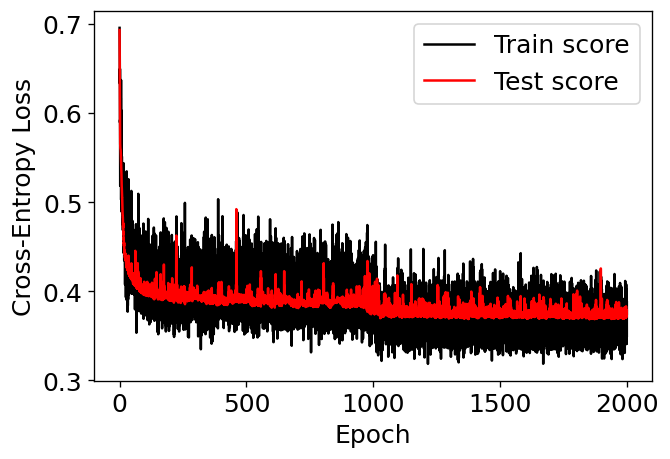

250 0.9240986717267552 0.7260833238388212
500 0.9259962049335864 0.7581367969313737
750 0.9259962049335864 0.7581367969313737
1000 0.9297912713472486 0.7583076981504691
1250 0.9392789373814042 0.8152937602066006
1500 0.9354838709677419 0.8102047016824275
1750 0.9430740037950665 0.8056283468155406
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
=>=>=> NUMBER OF EPOCHS: 250
TP = 98.8+/-5.706137047074842
TN = 379.6+/-12.142487389328432
FP = 11.6+/-9.931767214348108
FN = 37.0+/-4.9396356140913875
Acc = 0.9077798861480076+/-0.021655169059107544
TSS = 0.6976523198803004+/-0.04445577773471522
=>=>=> NUMBER OF EPOCHS: 500
TP = 103.4+/-3.3823069050575527
TN = 379.8+/-4.874423042781576
FP = 11.4+/-2.8000000000000003
FN = 32.4+/-6.343500610861483
Acc = 0.9168880455407971+/-0.015527341590496214
TSS = 0.7331560174746841+/-0.04574187463343198
=>=>=> NUMBER OF EPOCHS: 750
TP = 103.6+/-2.4979991993593593
TN = 381.2+/-5.81033561853358
FP = 10.0+/-3.03315017762062
FN = 32.2+/

In [23]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

100%|██████████| 2000/2000 [01:53<00:00, 17.54it/s]


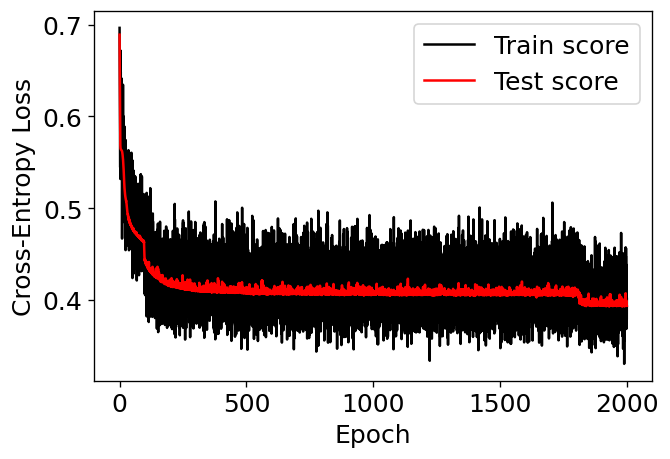

250 0.8994307400379506 0.6562917445899011
500 0.9070208728652751 0.6714247547803519
750 0.9108159392789373 0.6715201709858403
1000 0.905123339658444 0.6738674096408535
1250 0.9108159392789373 0.681481622838823
1500 0.9108159392789373 0.681481622838823
1750 0.9108159392789373 0.681481622838823
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 19.01it/s]


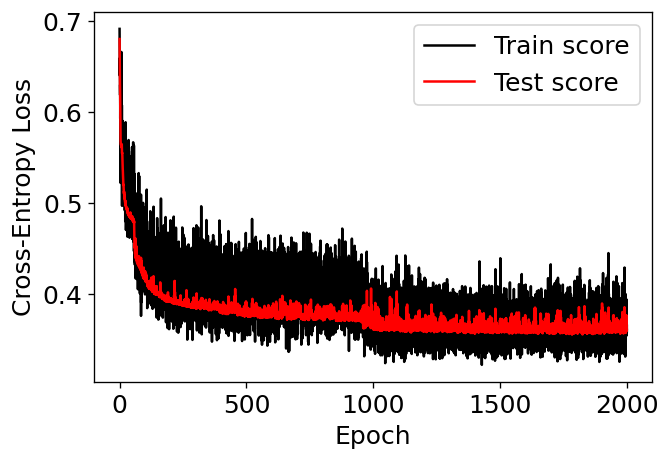

250 0.9259962049335864 0.7665356284111293
500 0.9335863377609108 0.7916300904545628
750 0.9354838709677419 0.78420670966757
1000 0.9487666034155597 0.8467997404679211
1250 0.9620493358633776 0.8695469638563413
1500 0.952561669829222 0.8668180603793748
1750 0.9582542694497154 0.869451547650853
---------------------------------------------


100%|██████████| 2000/2000 [01:46<00:00, 18.85it/s]


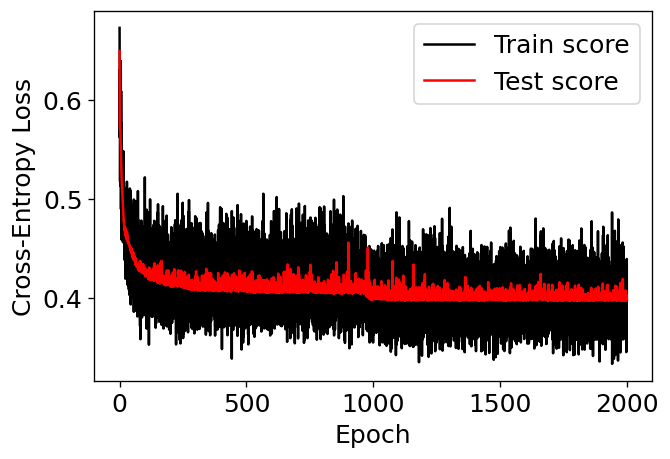

250 0.9070208728652751 0.6798004895053029
500 0.9032258064516129 0.6654120002966698
750 0.8804554079696395 0.6529518653118742
1000 0.9184060721062619 0.7044982570644516
1250 0.9089184060721063 0.7100793591930579
1500 0.9127134724857685 0.682915523251502
1750 0.9165085388994307 0.697304012460135
---------------------------------------------


100%|██████████| 2000/2000 [01:46<00:00, 18.84it/s]


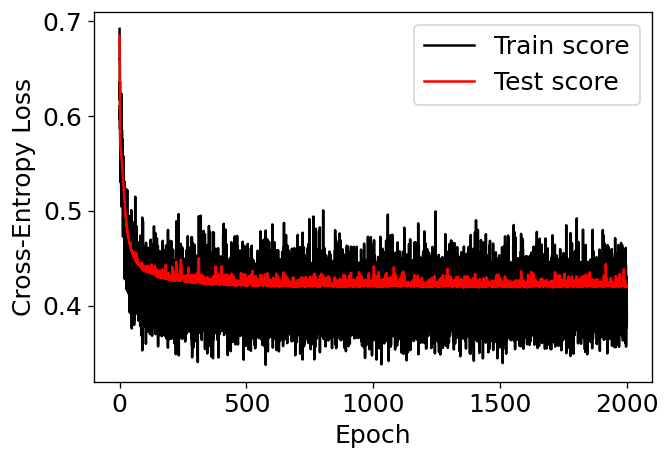

250 0.8861480075901328 0.6078995939461056
500 0.8975332068311196 0.6461978589885566
750 0.8918406072106262 0.61109265411591
1000 0.8823529411764706 0.6255260243632337
1250 0.8994307400379506 0.648781838316722
1500 0.9013282732447818 0.6468069398301957
1750 0.8994307400379506 0.6442229605020303
---------------------------------------------


100%|██████████| 2000/2000 [01:45<00:00, 18.88it/s]


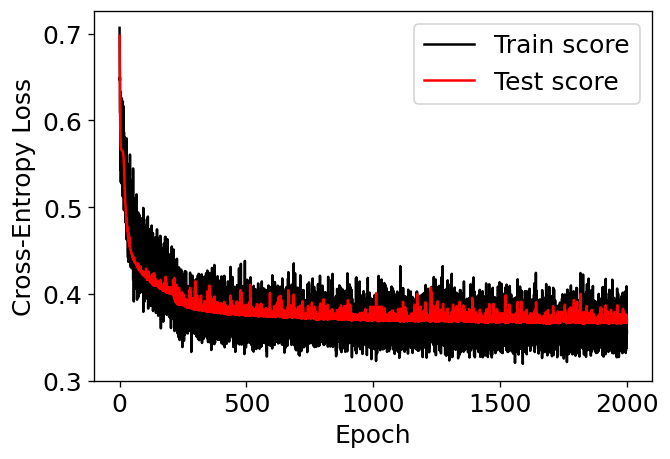

250 0.9392789373814042 0.8005392882913677
500 0.9411764705882353 0.8030838175534541
750 0.9392789373814042 0.8448027040370666
1000 0.9430740037950665 0.830219133340929
1250 0.9449715370018975 0.8376818199080931
1500 0.9487666034155597 0.8476890357373438
1750 0.9430740037950665 0.8203828187307736
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN1
=>=>=> NUMBER OF EPOCHS: 250
TP = 98.4+/-8.452218643646177
TN = 382.0+/-2.0
FP = 9.2+/-1.9390719429665317
FN = 37.4+/-10.423051376636307
Acc = 0.9115749525616698+/-0.018922126546213176
TSS = 0.7022133489487612+/-0.0711499267474897
=>=>=> NUMBER OF EPOCHS: 500
TP = 99.8+/-7.984985911070852
TN = 383.2+/-2.4819347291981715
FP = 8.0+/-1.5491933384829668
FN = 36.0+/-9.979979959899719
Acc = 0.9165085388994306+/-0.017473798001095005
TSS = 0.715549704414719+/-0.06741057056787955
=>=>=> NUMBER OF EPOCHS: 750
TP = 100.6+/-11.48216007552586
TN = 379.8+/-8.565045242145544
FP = 11.4+/-7.391887445030532
FN = 35.2+/-13.25745073534124


In [13]:
# NETWORK: VDFCNN_6060_CNN1_CONN1
ARCH = 'VDFCNN_6060_CNN1_CONN1'

tp = np.zeros([7,5], dtype=int)
tn = np.zeros([7,5], dtype=int)
fp = np.zeros([7,5], dtype=int)
fn = np.zeros([7,5], dtype=int)
acc = np.zeros([7,5], dtype=float)
tss = np.zeros([7,5], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  if (n_e >= 5): continue

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN1().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 2000
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_indexes = np.arange(250,2000,250)*n_iterations

    oi = 6
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  for oi in range (0, 7, 1):
    optim_index = optim_indexes[oi]
    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)
    tp[oi,n_e], tn[oi,n_e], fp[oi,n_e], fn[oi,n_e], acc[oi,n_e], tss[oi,n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
    print(oi*250+250,acc[oi,n_e], tss[oi,n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
for oi in range (0, 7, 1):
  print("=>=>=> NUMBER OF EPOCHS:", oi*250+250)
  print("TP = " + str(np.mean(tp[oi,:])) + "+/-" + str(np.std(tp[oi,:])))
  print("TN = " + str(np.mean(tn[oi,:])) + "+/-" + str(np.std(tn[oi,:])))
  print("FP = " + str(np.mean(fp[oi,:])) + "+/-" + str(np.std(fp[oi,:])))
  print("FN = " + str(np.mean(fn[oi,:])) + "+/-" + str(np.std(fn[oi,:])))
  print("Acc = " + str(np.mean(acc[oi,:])) + "+/-" + str(np.std(acc[oi,:])))
  print("TSS = " + str(np.mean(tss[oi,:])) + "+/-" + str(np.std(tss[oi,:])))

## Best Network Architecture

CONCLUSION:

Best network configuration: VDFCNN_6060_CNN1_CONN2 with 1750 epochs

Running for the best configuration now...

100%|██████████| 1750/1750 [01:25<00:00, 20.53it/s]


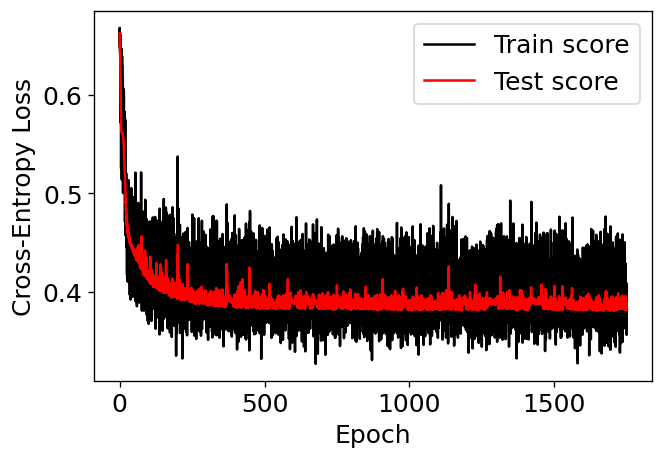

0.9335863377609108 -1
0.9335863377609108 0.7617457348956147
---------------------------------------------


100%|██████████| 1750/1750 [01:07<00:00, 25.93it/s]


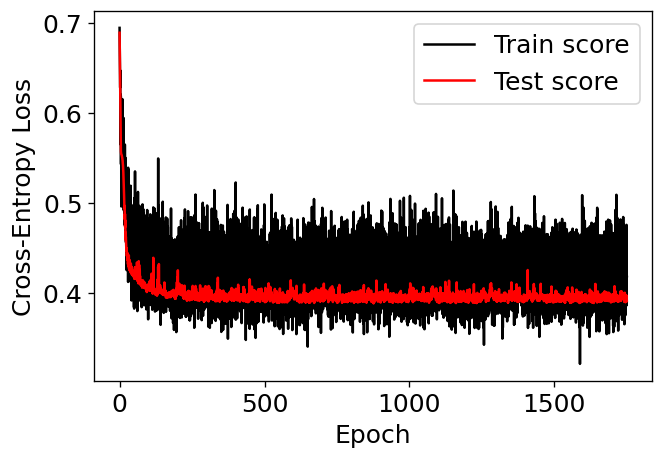

0.9259962049335864 -1
0.9259962049335864 0.706766917293233
---------------------------------------------


100%|██████████| 1750/1750 [01:04<00:00, 27.13it/s]


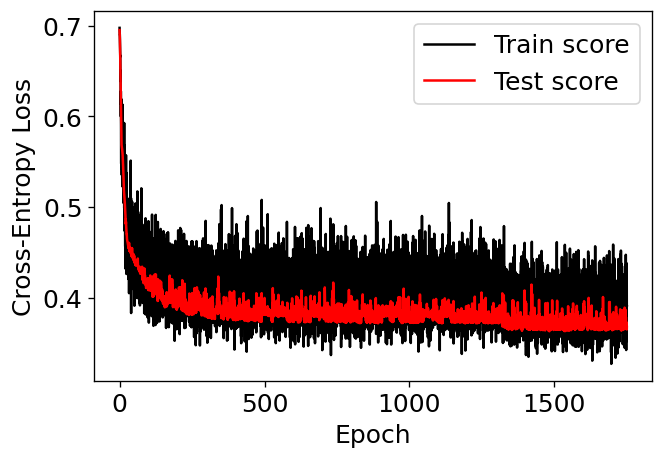

0.9506641366223909 -1
0.9506641366223909 0.8406511903878959
---------------------------------------------


100%|██████████| 1750/1750 [01:07<00:00, 26.09it/s]


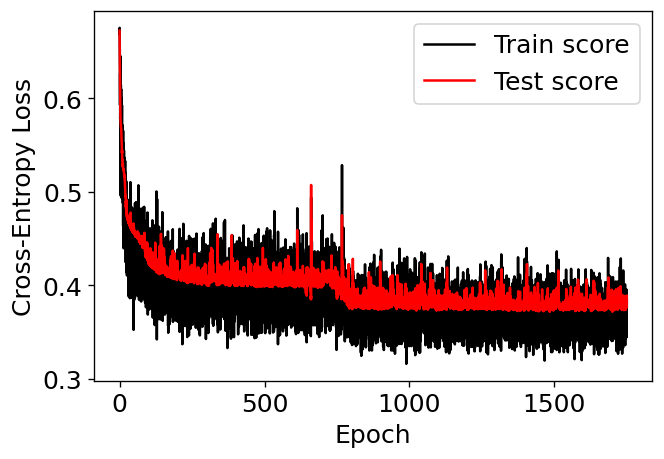

0.9316888045540797 -1
0.9316888045540797 0.7975636766334442
---------------------------------------------


100%|██████████| 1750/1750 [01:05<00:00, 26.92it/s]


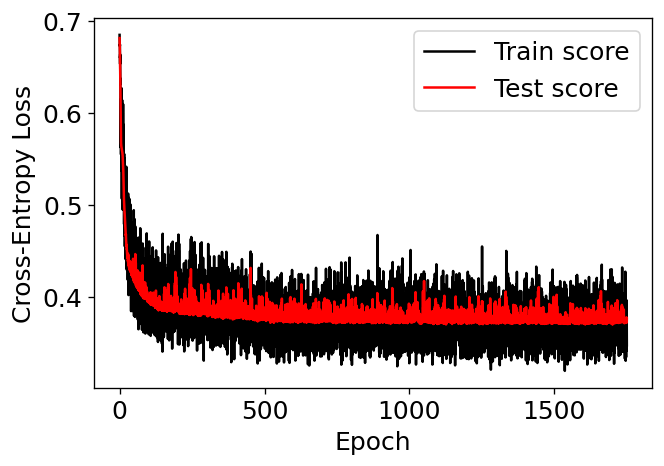

0.937381404174573 -1
0.937381404174573 0.7783221298089704
---------------------------------------------


100%|██████████| 1750/1750 [01:05<00:00, 26.86it/s]


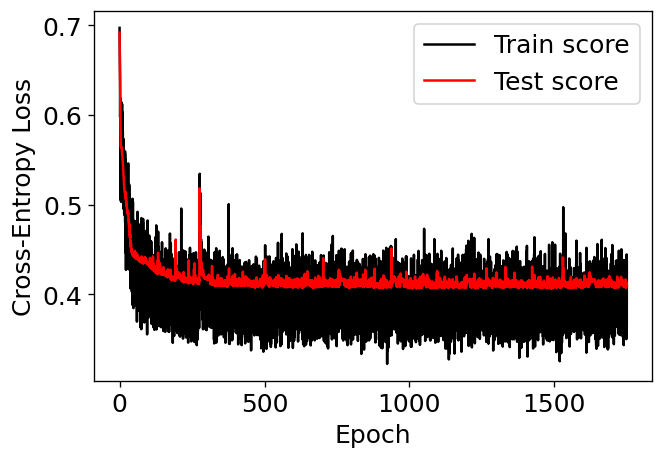

0.9070208728652751 -1
0.9070208728652751 0.6613327894385522
---------------------------------------------


100%|██████████| 1750/1750 [01:05<00:00, 26.54it/s]


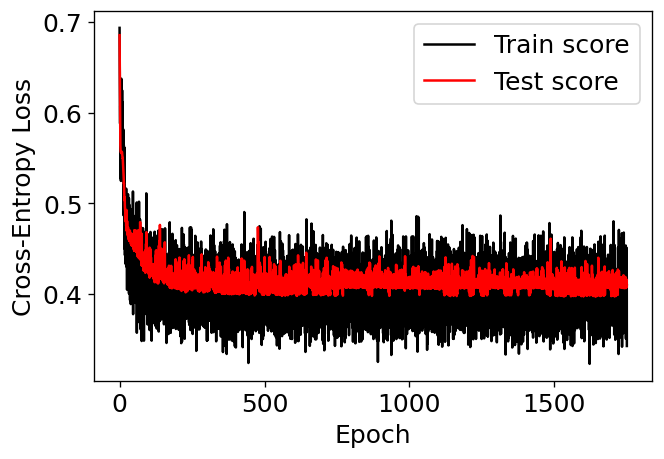

0.9070208728652751 -1
0.9070208728652751 0.6748110831234256
---------------------------------------------


100%|██████████| 1750/1750 [01:04<00:00, 27.03it/s]


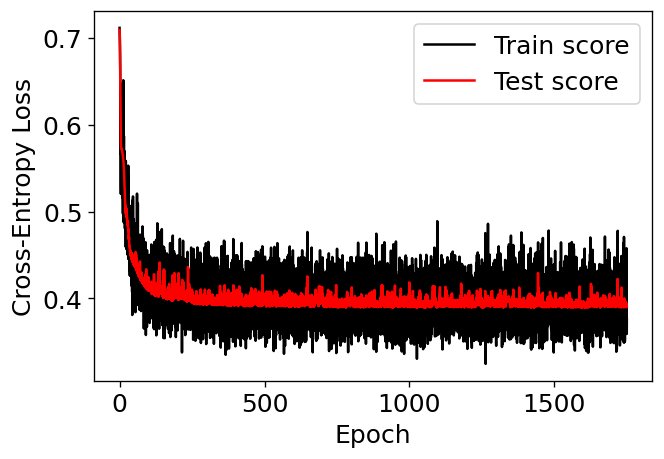

0.9278937381404174 -1
0.9278937381404174 0.758937180152785
---------------------------------------------


100%|██████████| 1750/1750 [01:05<00:00, 26.74it/s]


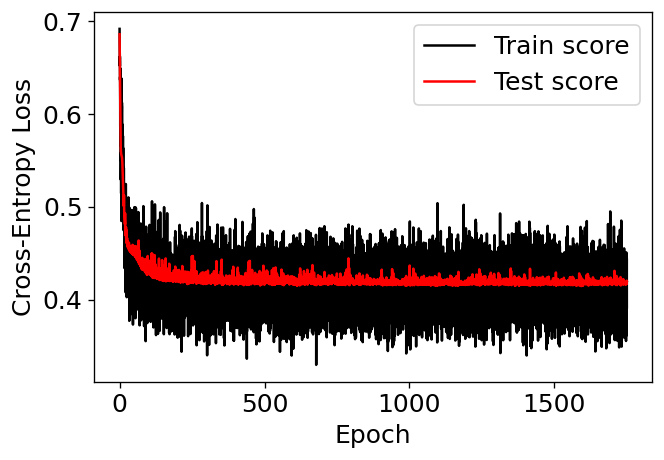

0.8937381404174574 -1
0.8937381404174574 0.5763702232090686
---------------------------------------------


100%|██████████| 1750/1750 [01:06<00:00, 26.36it/s]


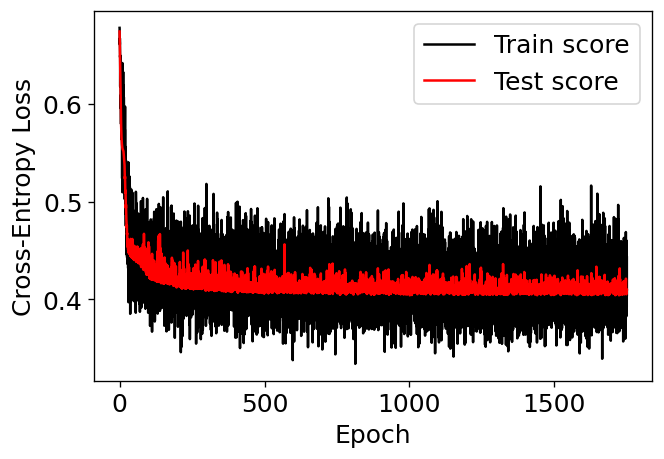

0.9127134724857685 -1
0.9127134724857685 0.6431692913385827
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
TP = 98.7+/-13.505924625881784
TN = 387.6+/-6.959885056522126
FP = 5.1+/-3.645545226711637
FN = 35.6+/-10.229369482035537
Acc = 0.9227703984819735+/-0.01632430073169117
TSS = 0.7199670216281573+/-0.07708733285096532


In [14]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for n_e, split_indexes in enumerate(data_split.split(labels_allmoments)):

  train_index, test_index = split_indexes
  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn(f_test, labels_optim)

    print(_acc, optim_index)
    if (_acc < 0.88):
      print("RERUNNING THE SAMPLE...")
      continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

# Tests for individual runs

In [12]:
simfiles = [\
'particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
'particles.d11_A0.75Hepp_beta1_256',\
'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
'particles.d11_E11Ap4.3Aa1.6',\
'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
'particles.d11_He++A10_256_iden0eps0',\
'particles.d11_He++v2_256_iden0eps1e-4t600',\
'particles.d11_He++vd1.5_256_iden0eps1e-4',\
'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
'particles.d11_vap1.5Ap1.5Aa1rdna_0.007',\
'particles.d11_e260945ap1.30.5_1',\
'particles.d11_e260955ap2.20.4_2',\
'particles.d11_e261013ap1.50.6_3',\
'particles.d11_e261016ap1.70.6_4',\
'particles.d11_e261019ap1.50.4_5',\
'particles.d11_e261022ap1.40.4_6',\
'particles.d11_e261040ap1.40.4_7',\
'particles.d11_pv1.4av2Ap2Apb2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2Ap2Apb2beta_pb0.429_128_128x2_dx0.75',\
'particles.d11_pv2av1.4Ap1Aa1betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Aa2betac0.214betab0.858_128_128x4_dx0.75',\
'particles.d11_pv2av1.4Ap2Ab2beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x4_dx0.75_t3000',\
'particles.d11_pv2av2Ap2Aa2beta0.429_128_128x4_dx0.75_t3000']

In [13]:
def outputclass_analysis_scorereturn_spec(test_labels, predicted_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(test_labels)):
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 0) ): tn += 1
        if ( (test_labels[i] == 0) and (predicted_labels[i] == 1) ): fp += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 0) ): fn += 1
        if ( (test_labels[i] == 1) and (predicted_labels[i] == 1) ): tp += 1
    acc = (tp+tn)/(tp+fn+fp+tn)
    if ( ((tp + fn) == 0) or ((fp + tn) == 0) ):
      tss = -1
    else:
      tss = tp/(tp+fn) - fp/(fp+tn)
    return tp, tn, fp, fn, acc, tss

100%|██████████| 1750/1750 [01:00<00:00, 28.74it/s]


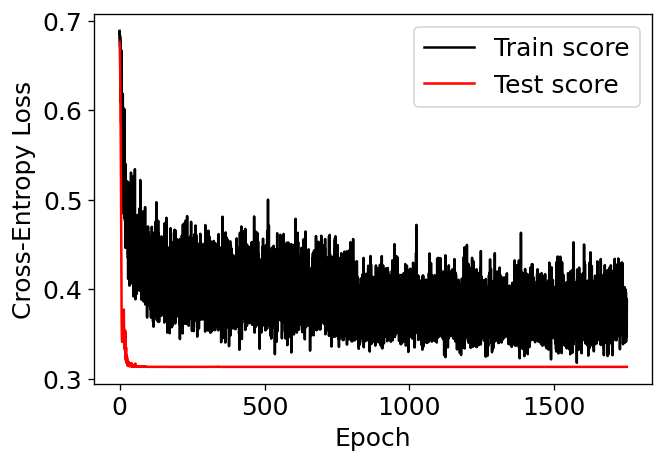

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.64it/s]


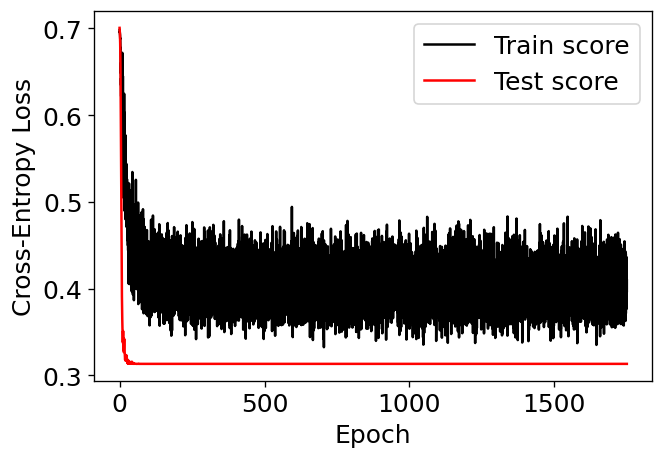

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.62it/s]


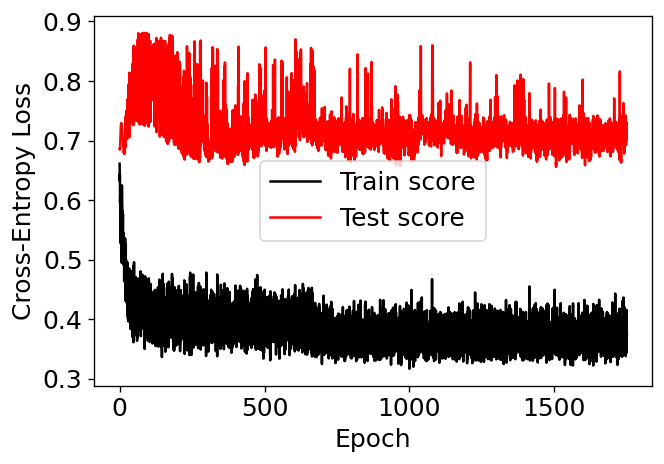

0.5652173913043478 -1
0.5652173913043478 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.71it/s]


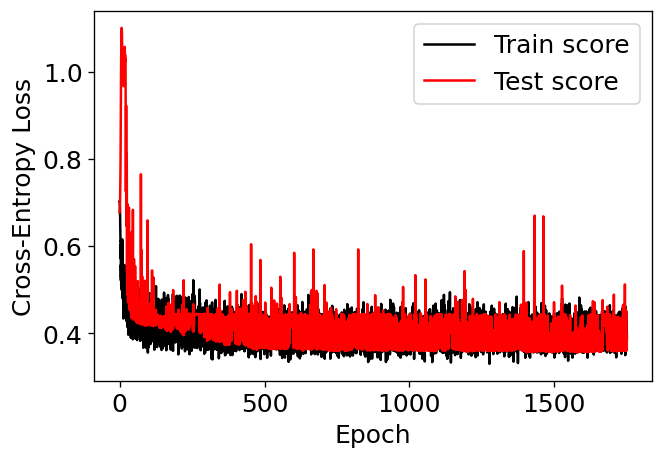

0.8913043478260869 -1
0.8913043478260869 0.16666666666666663
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.10it/s]


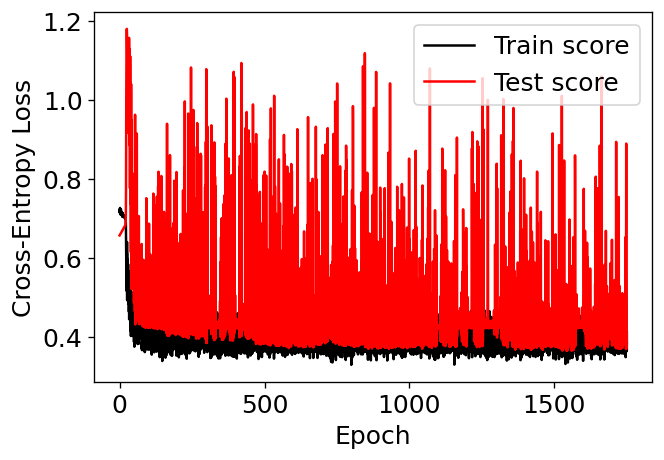

0.9347826086956522 -1
0.9347826086956522 0.4
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.16it/s]


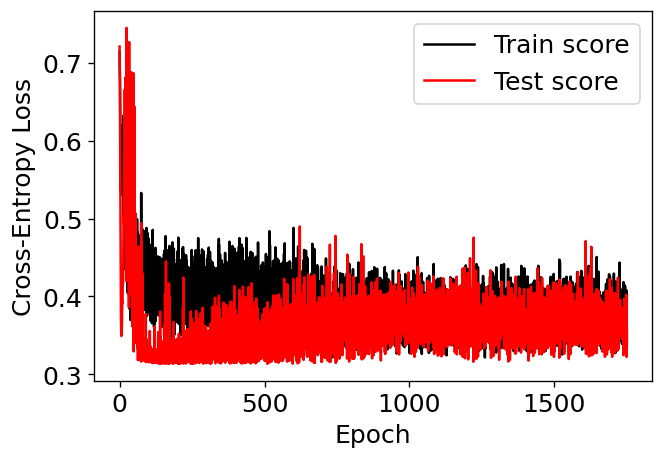

0.9375 -1
0.9375 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.82it/s]


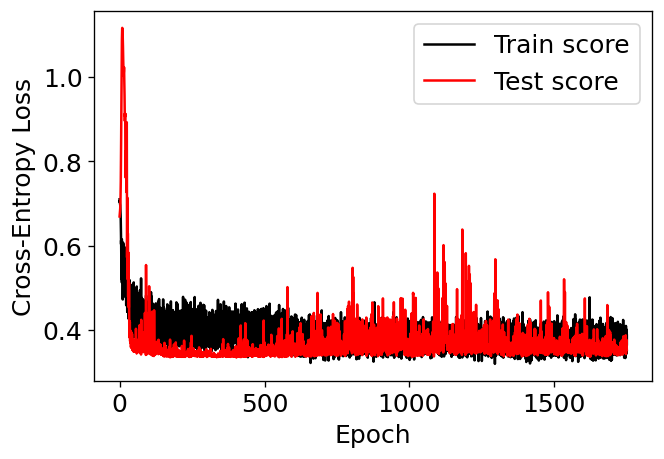

0.9782608695652174 -1
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.39it/s]


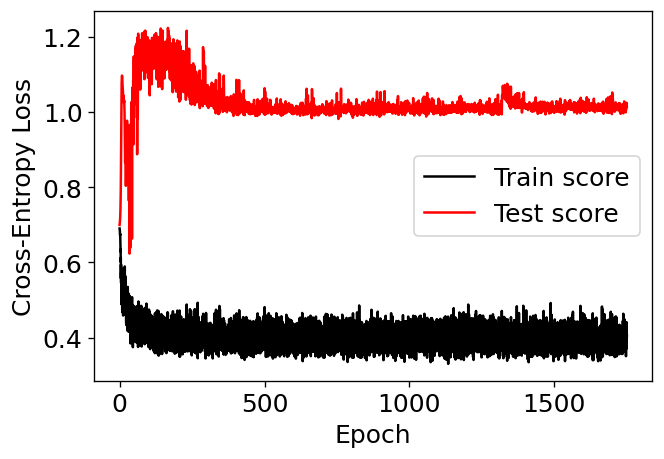

0.3 -1
0.3 0.25
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.27it/s]


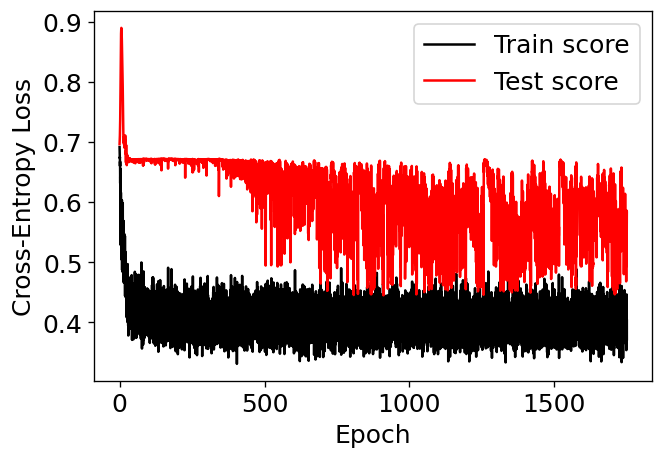

0.6410256410256411 -1
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:55<00:00, 31.45it/s]


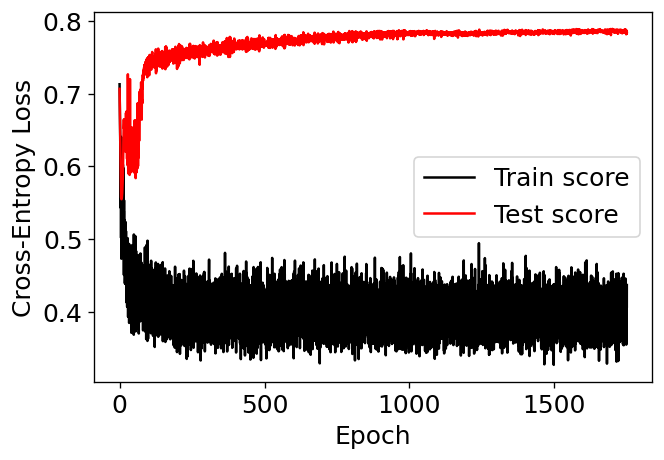

0.5202702702702703 -1
0.5202702702702703 -0.18008255933952527
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.01it/s]


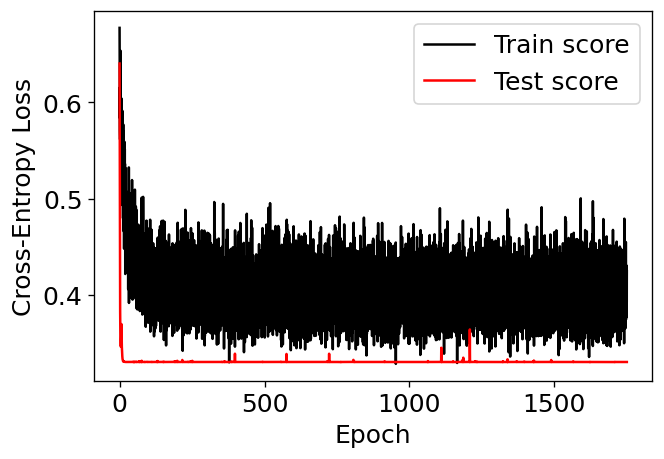

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.10it/s]


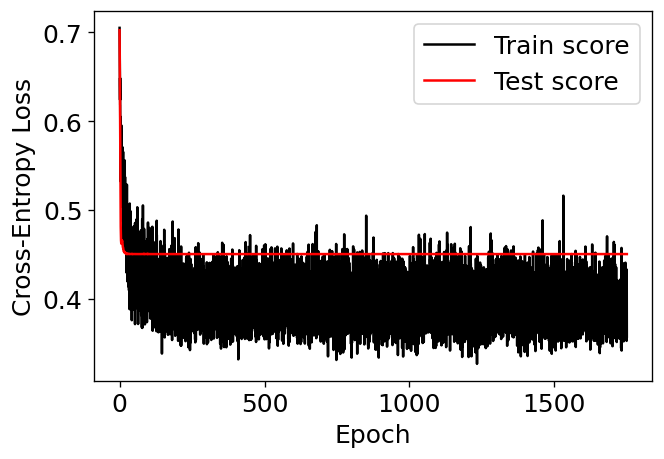

0.863013698630137 -1
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.92it/s]


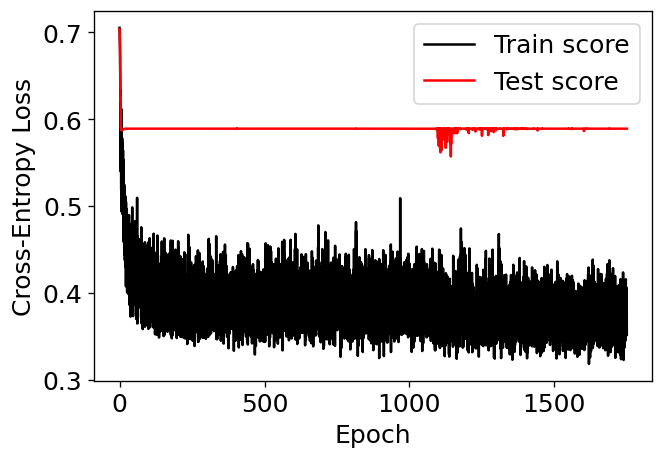

0.7241379310344828 -1
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.05it/s]


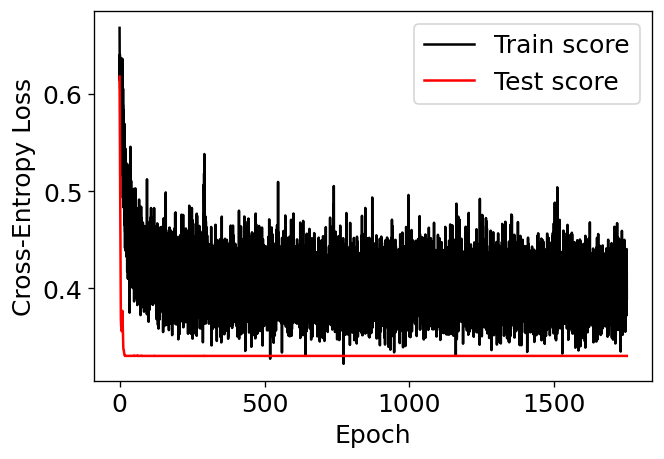

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 31.02it/s]


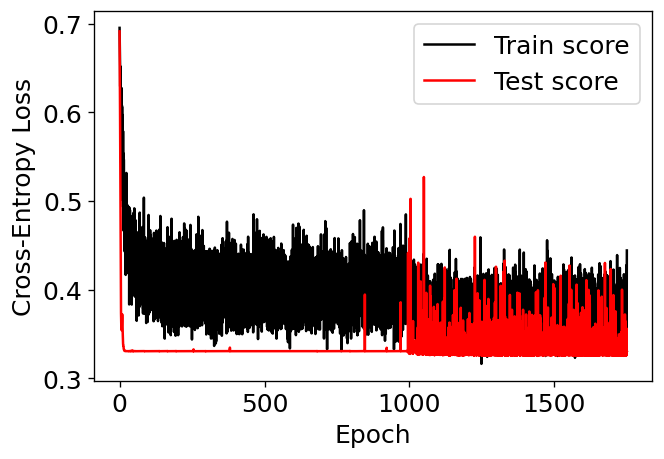

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:56<00:00, 30.87it/s]


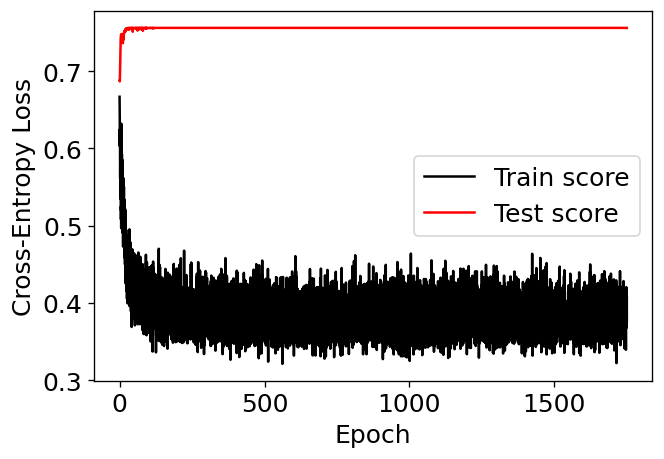

0.5573770491803278 -1
0.5573770491803278 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.40it/s]


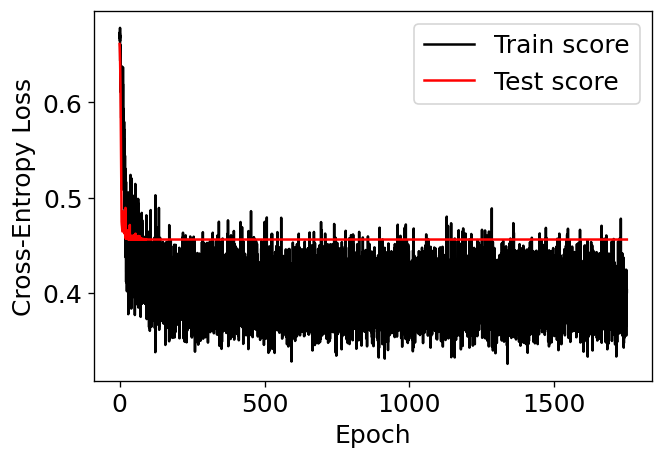

0.8571428571428571 -1
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.34it/s]


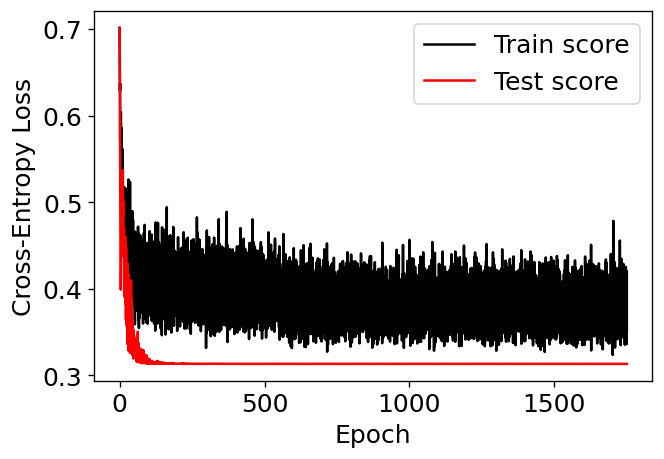

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.43it/s]


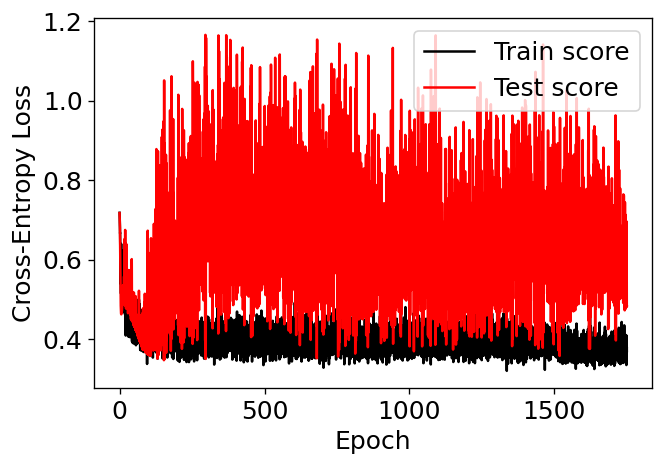

0.8181818181818182 -1
0.8181818181818182 0.7894736842105263
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 29.90it/s]


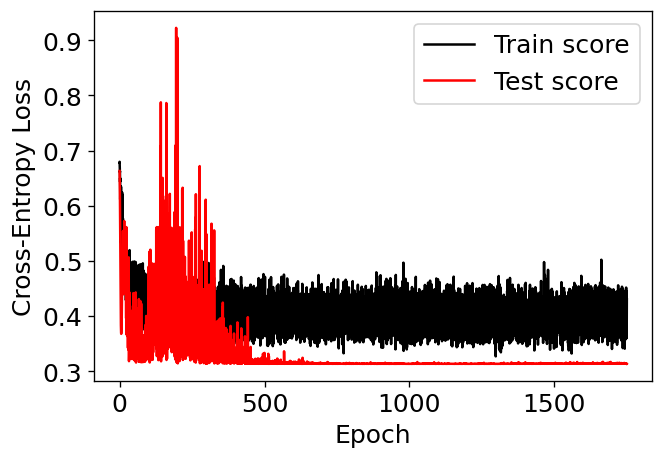

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 29.92it/s]


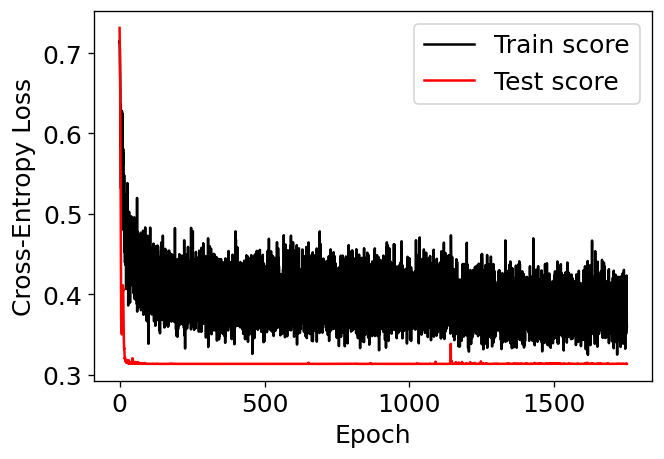

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:59<00:00, 29.39it/s]


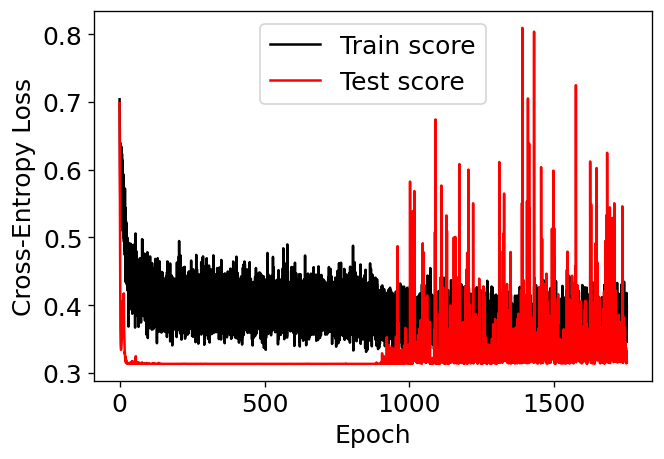

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:00<00:00, 29.02it/s]


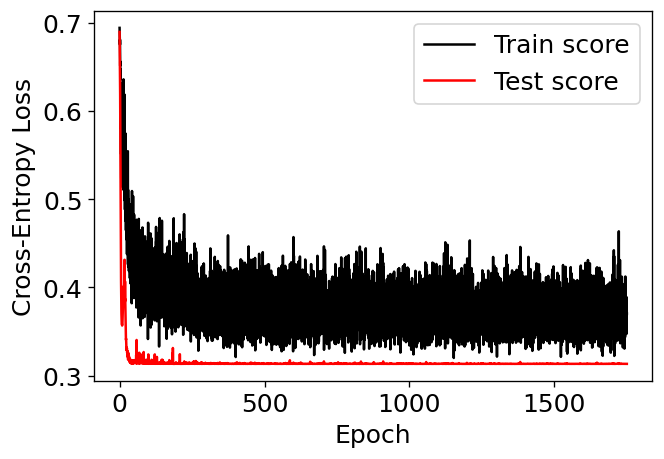

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:59<00:00, 29.57it/s]


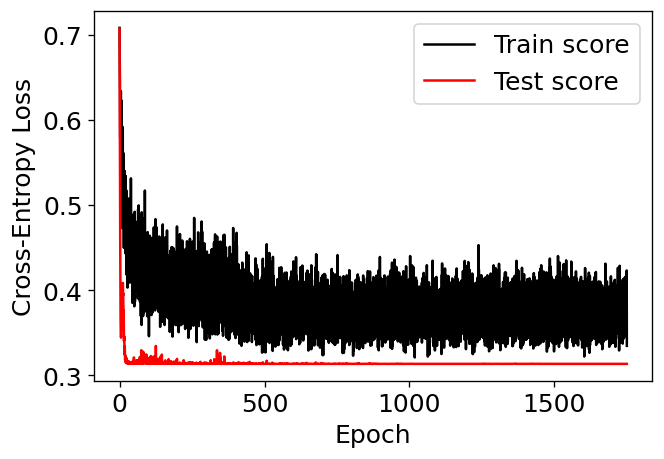

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.26it/s]


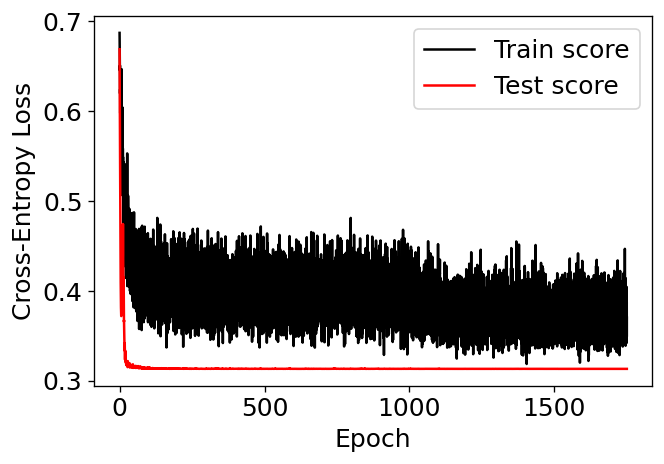

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.33it/s]


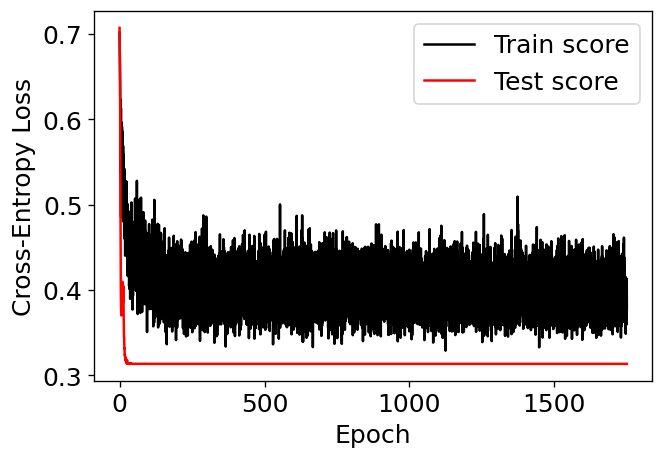

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 30.06it/s]


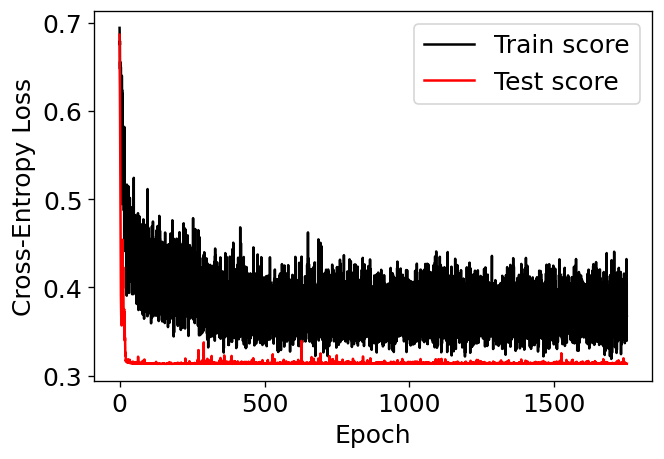

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:58<00:00, 30.10it/s]


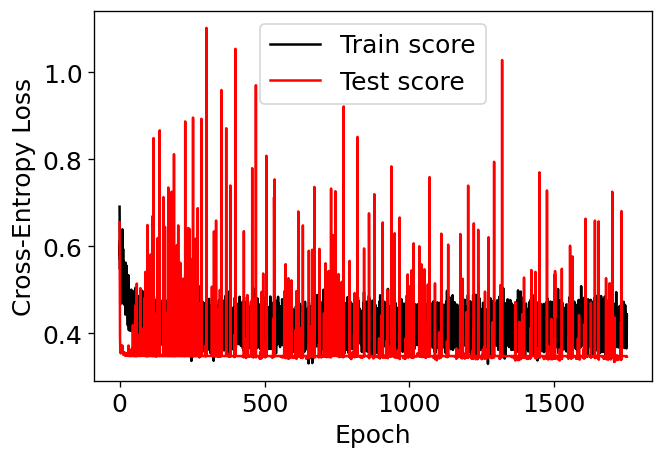

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.55it/s]


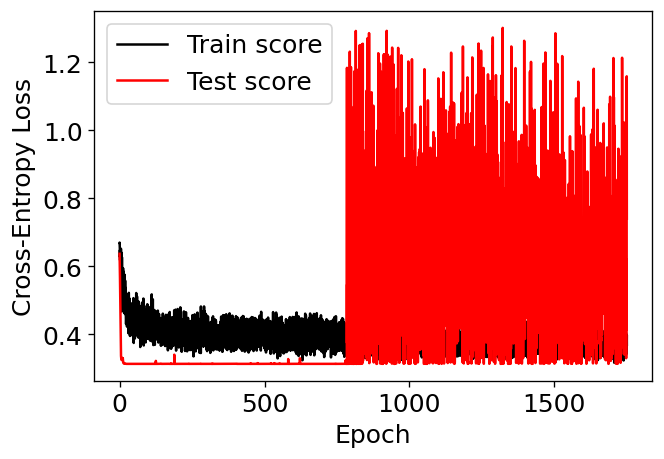

0.5 -1
0.5 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.69it/s]


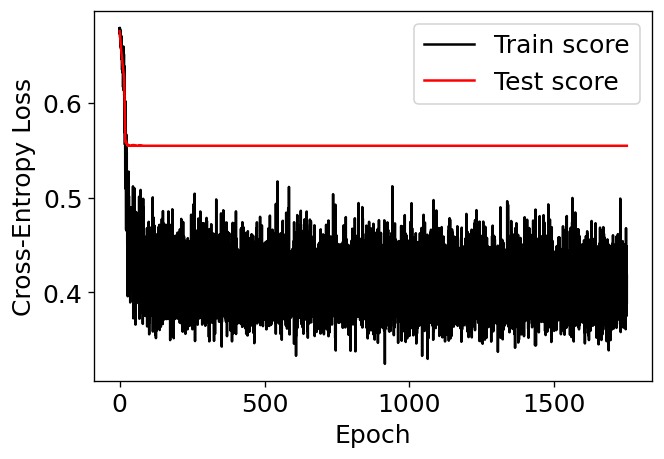

0.7586206896551724 -1
0.7586206896551724 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.62it/s]


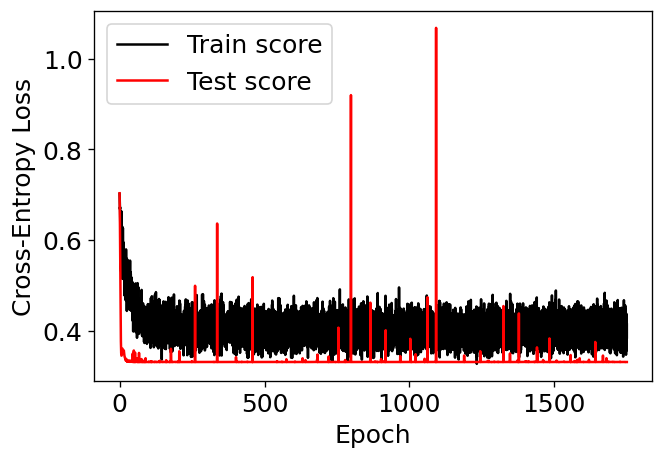

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.55it/s]


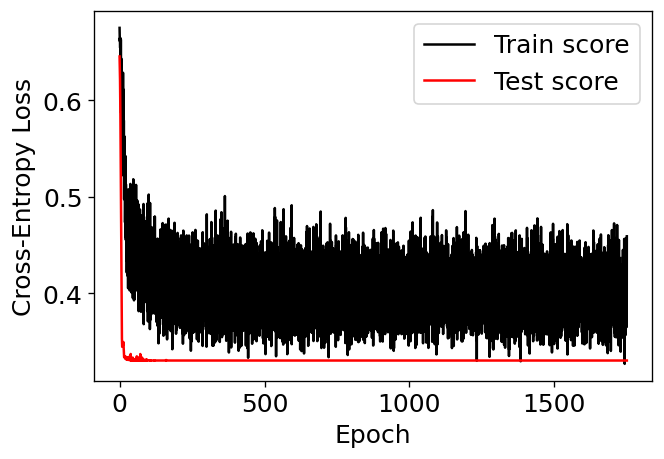

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.65it/s]


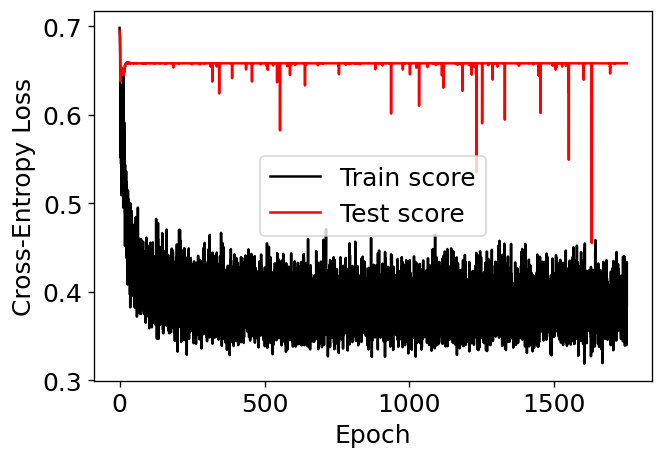

0.6551724137931034 -1
0.6551724137931034 0.0
---------------------------------------------


100%|██████████| 1750/1750 [00:57<00:00, 30.57it/s]


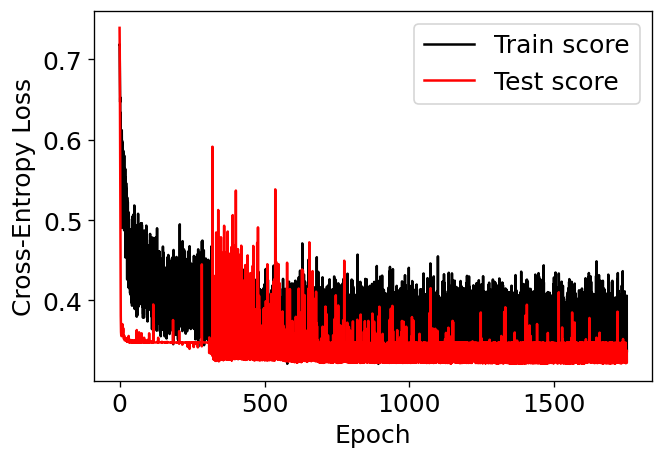

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------
ARCH = VDFCNN_4040_CNN1_CONN2
TP = 6.088235294117647+/-14.394377266343033
TN = 31.91176470588235+/-22.82976339968974
FP = 2.735294117647059+/-8.6613027940354
FN = 6.205882352941177+/-12.727412314427992
Acc = 0.8631422109562356+/-0.18762798493926525
TSS = -0.3404100649547745+/-0.5414058438875897
[1.         1.         0.56521739 0.89130435 0.93478261 0.9375
 0.97826087 0.3        0.64102564 0.52027027 0.98275862 0.8630137
 0.72413793 0.98275862 0.98275862 0.55737705 0.85714286 1.
 0.81818182 1.         1.         1.         1.         1.
 1.         1.         1.         0.96551724 0.5        0.75862069
 0.98275862 0.98275862 0.65517241 0.96551724]
[-1.         -1.          0.          0.16666667  0.4        -1.
  0.          0.25        0.         -0.18008256  0.          0.
  0.          0.          0.          0.          0.         -1.
  0.78947368 -1.         -1.         -1.         -1.      

In [14]:
# NETWORK: VDFCNN_4040_CNN1_CONN2
ARCH = 'VDFCNN_4040_CNN1_CONN2'

tp = np.zeros([34], dtype=int)
tn = np.zeros([34], dtype=int)
fp = np.zeros([34], dtype=int)
fn = np.zeros([34], dtype=int)
acc = np.zeros([34], dtype=float)
tss = np.zeros([34], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_4040_aug[train_index], featurevector_allvdfs_all_4040_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_4040_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)

100%|██████████| 1750/1750 [01:18<00:00, 22.24it/s]


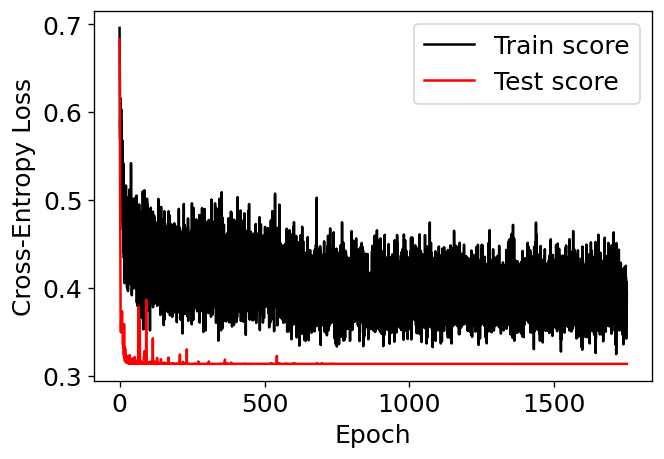

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.86it/s]


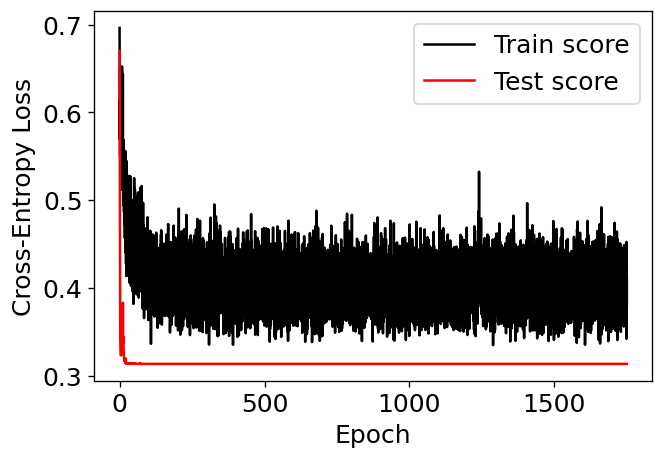

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.76it/s]


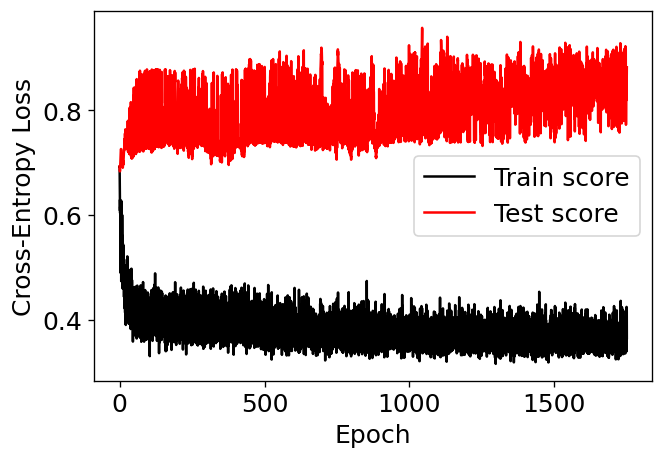

0.34782608695652173 -1
0.34782608695652173 -0.3384615384615384
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.64it/s]


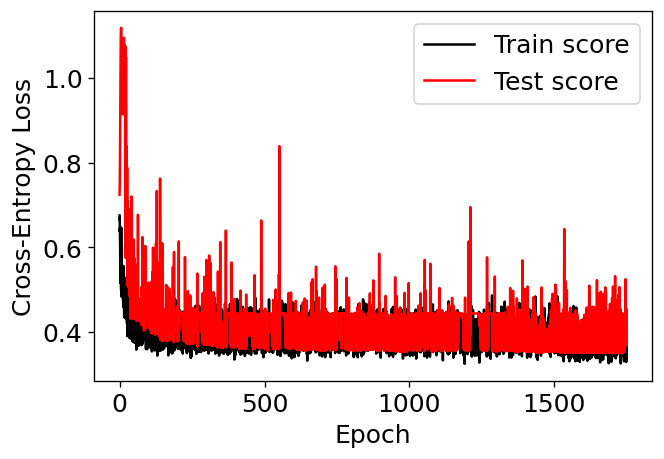

0.9130434782608695 -1
0.9130434782608695 0.9
---------------------------------------------


100%|██████████| 1750/1750 [01:21<00:00, 21.39it/s]


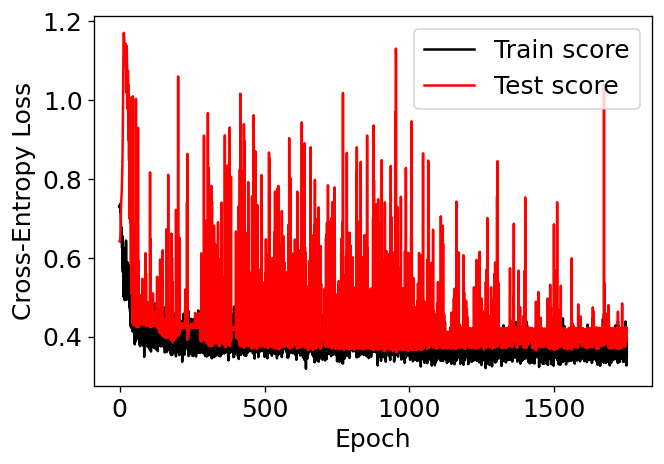

0.8913043478260869 -1
0.8913043478260869 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.75it/s]


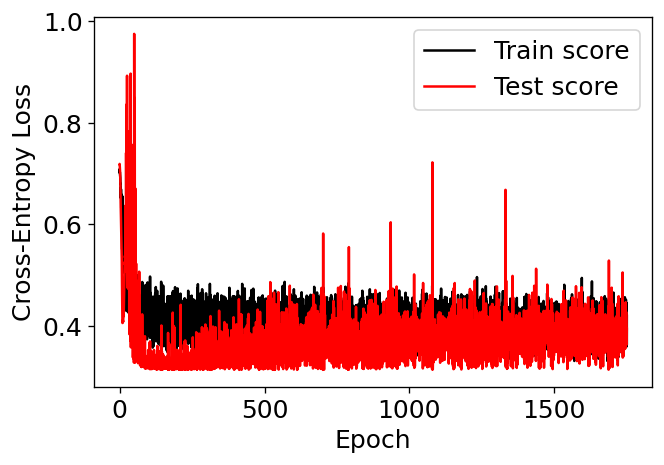

0.9166666666666666 -1
0.9166666666666666 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.71it/s]


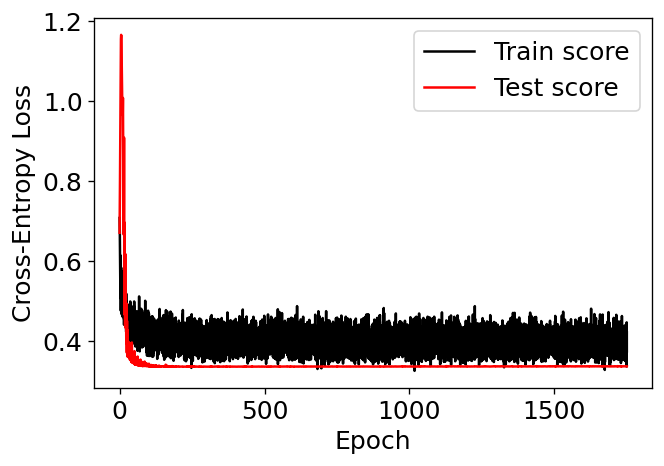

0.9782608695652174 -1
0.9782608695652174 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:18<00:00, 22.37it/s]


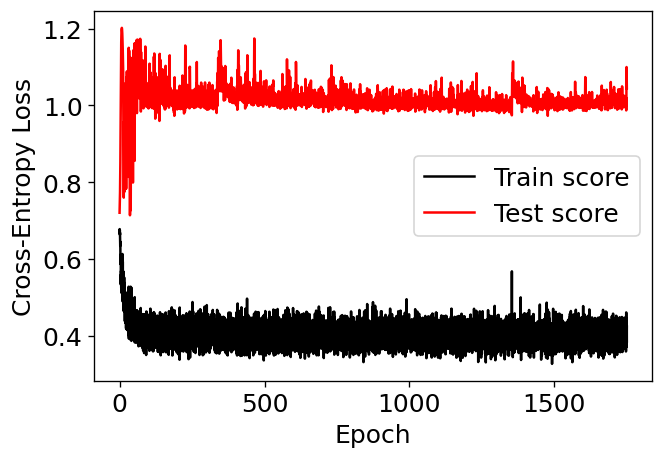

0.26666666666666666 -1
0.26666666666666666 0.21428571428571427
---------------------------------------------


100%|██████████| 1750/1750 [01:18<00:00, 22.23it/s]


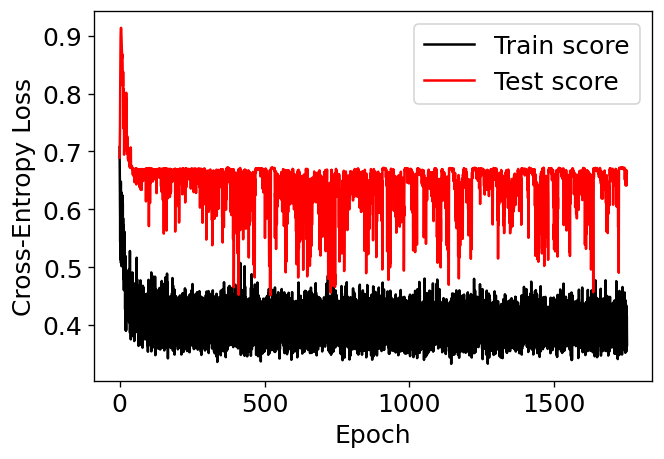

0.6410256410256411 -1
0.6410256410256411 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:18<00:00, 22.32it/s]


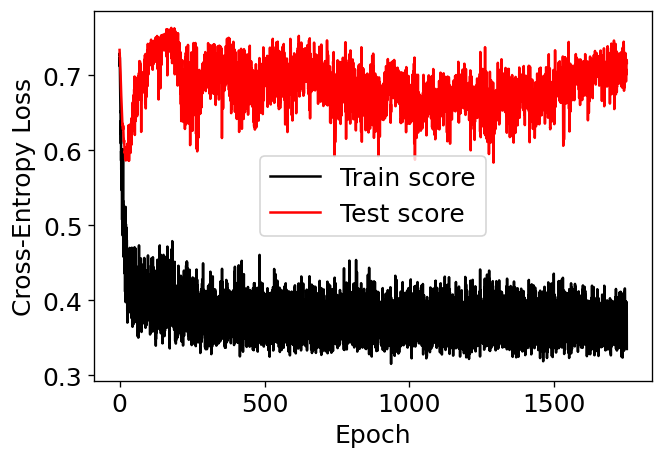

0.4864864864864865 -1
0.4864864864864865 -0.327141382868937
---------------------------------------------


100%|██████████| 1750/1750 [01:20<00:00, 21.79it/s]


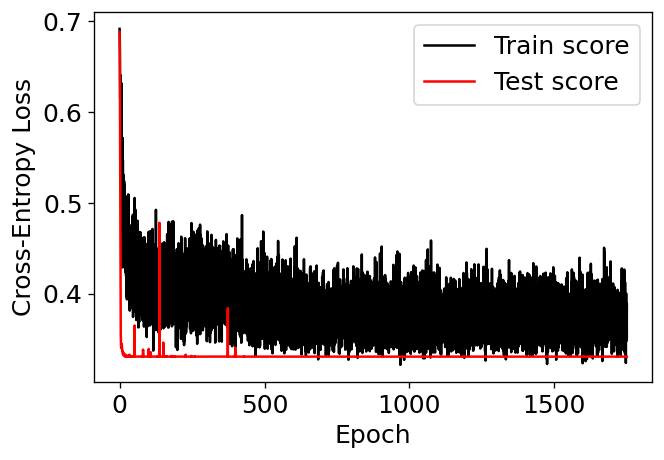

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:19<00:00, 22.15it/s]


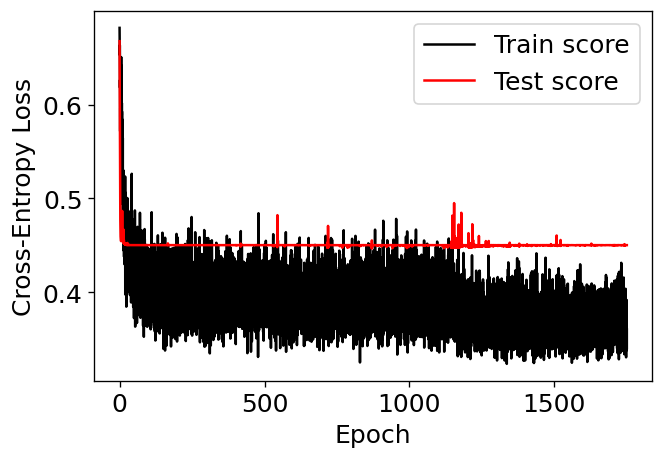

0.863013698630137 -1
0.863013698630137 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:21<00:00, 21.51it/s]


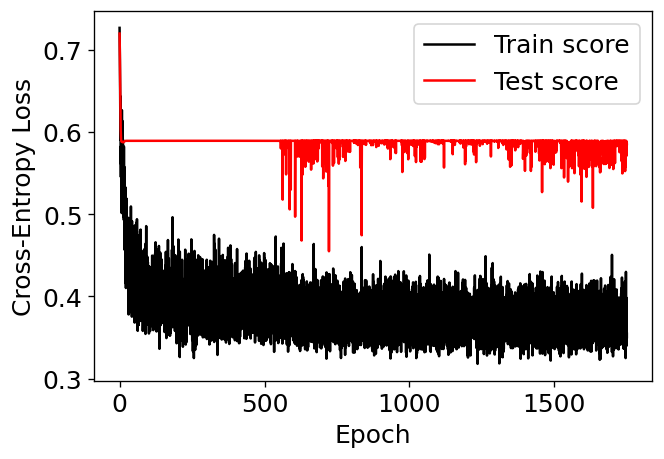

0.7241379310344828 -1
0.7241379310344828 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:21<00:00, 21.50it/s]


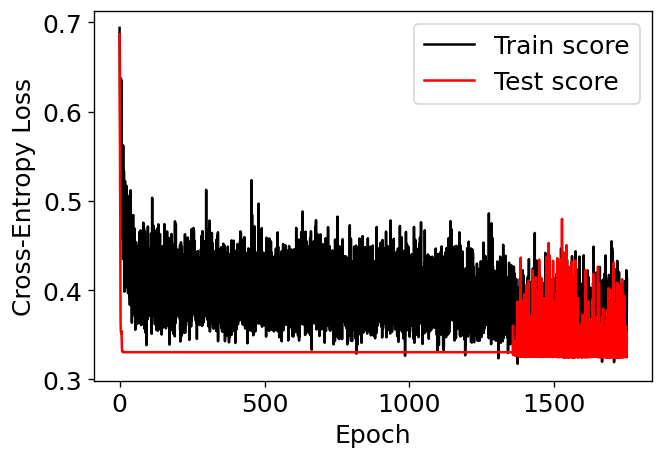

0.9655172413793104 -1
0.9655172413793104 0.9649122807017544
---------------------------------------------


100%|██████████| 1750/1750 [01:21<00:00, 21.51it/s]


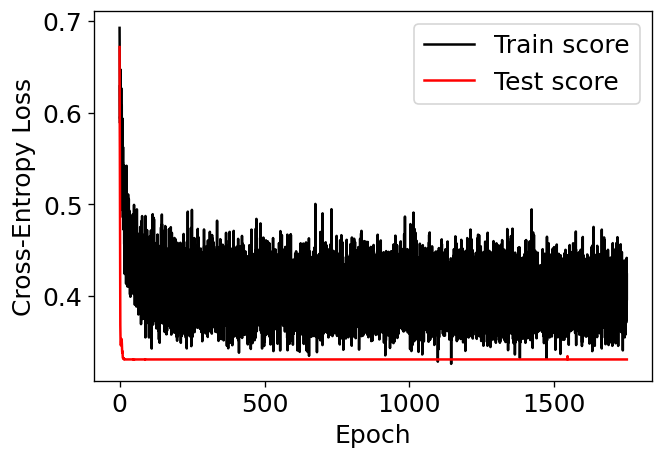

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:22<00:00, 21.22it/s]


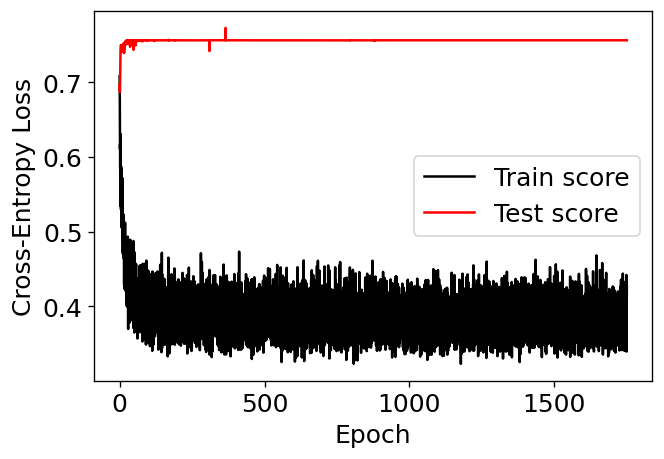

0.5573770491803278 -1
0.5573770491803278 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:21<00:00, 21.38it/s]


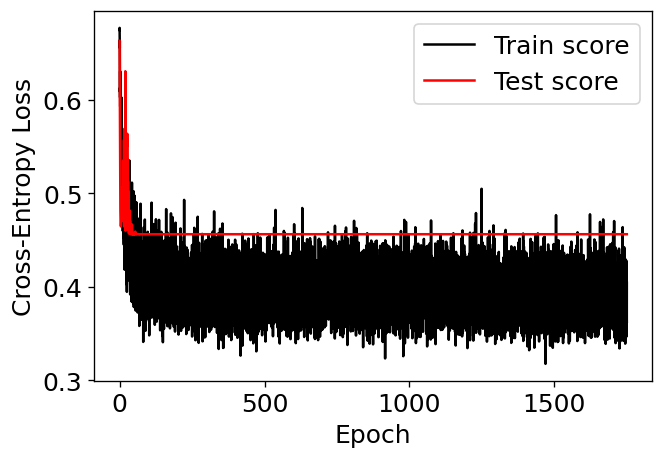

0.8571428571428571 -1
0.8571428571428571 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:22<00:00, 21.16it/s]


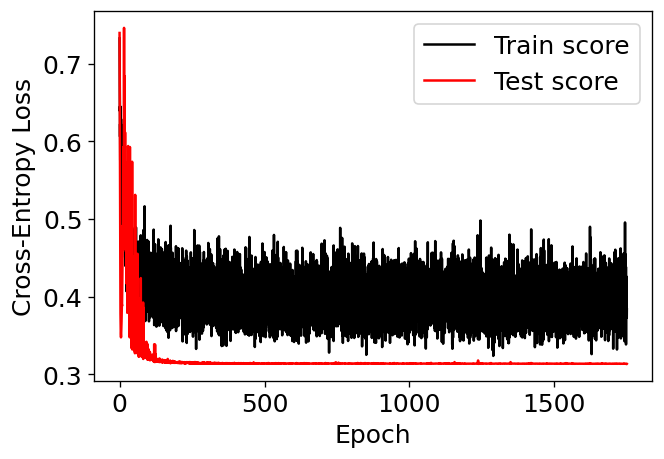

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:29<00:00, 19.47it/s]


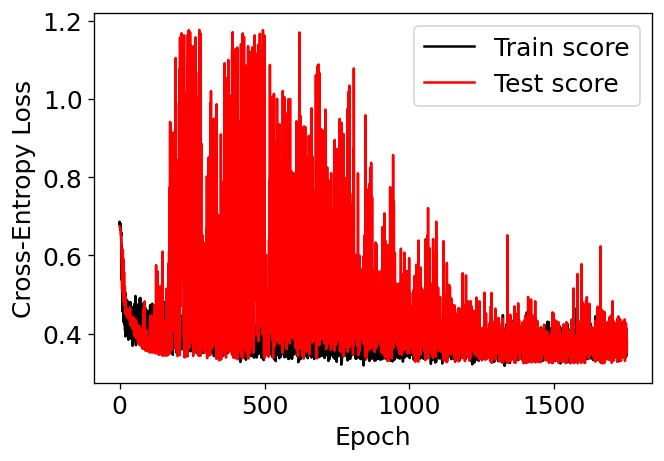

0.9545454545454546 -1
0.9545454545454546 0.9473684210526316
---------------------------------------------


100%|██████████| 1750/1750 [01:29<00:00, 19.54it/s]


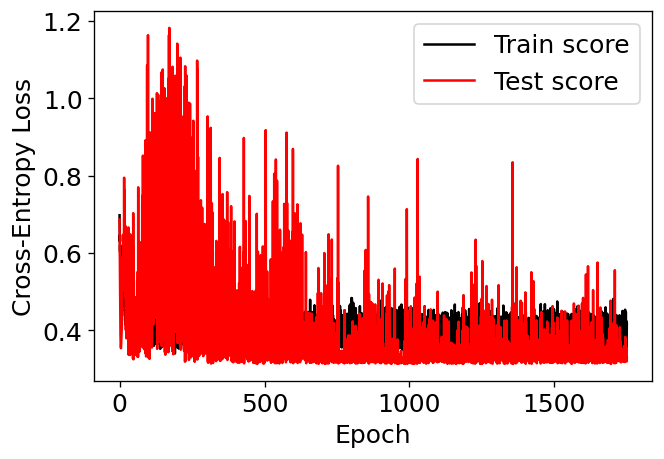

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:30<00:00, 19.34it/s]


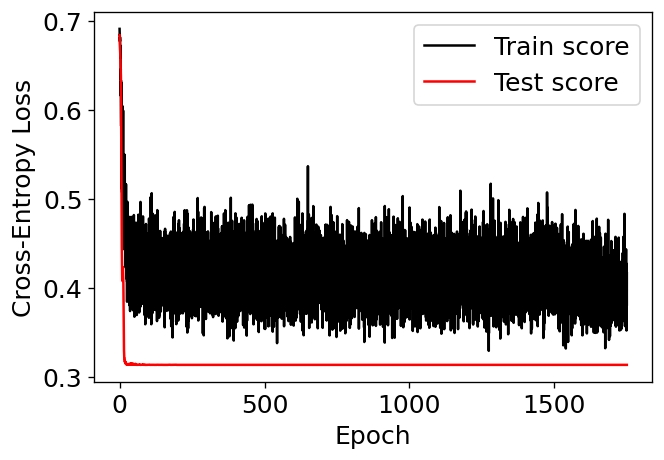

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:24<00:00, 20.64it/s]


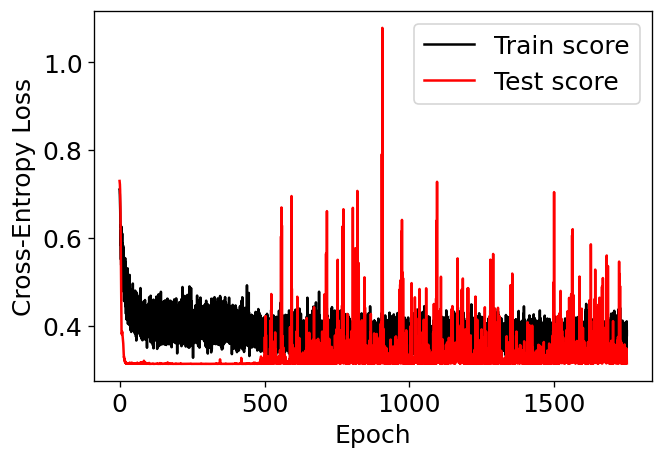

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:24<00:00, 20.68it/s]


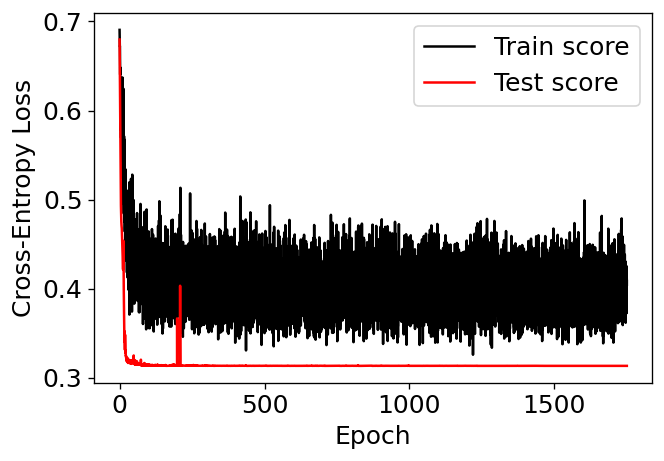

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:27<00:00, 19.97it/s]


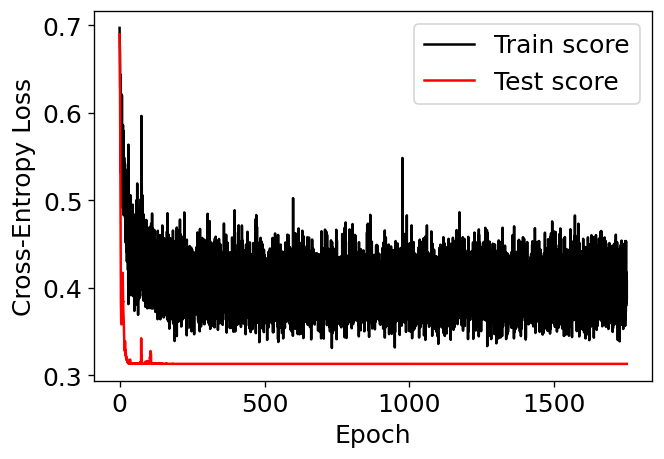

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:28<00:00, 19.76it/s]


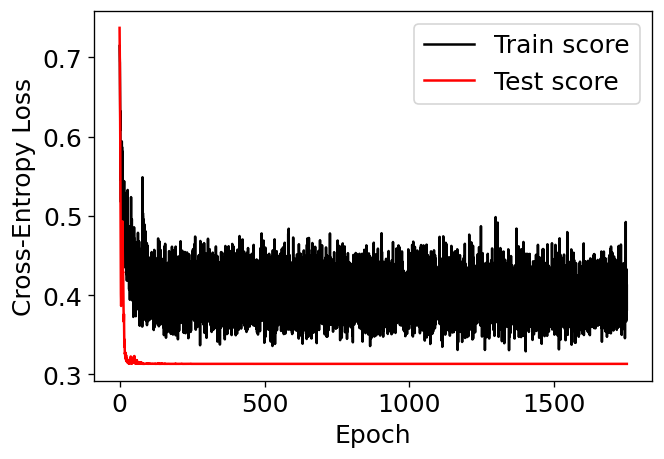

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:27<00:00, 19.92it/s]


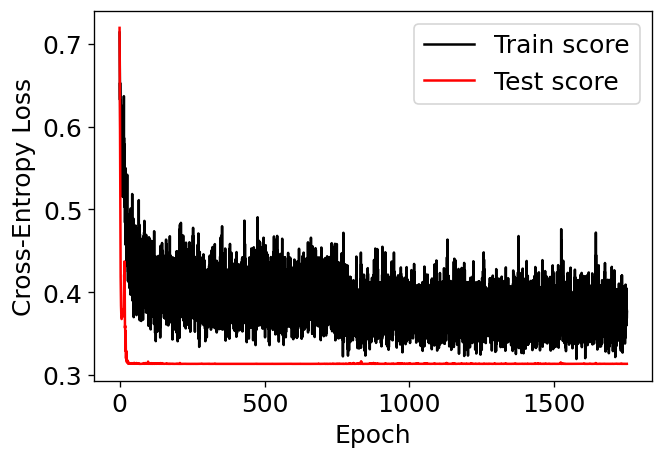

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:28<00:00, 19.82it/s]


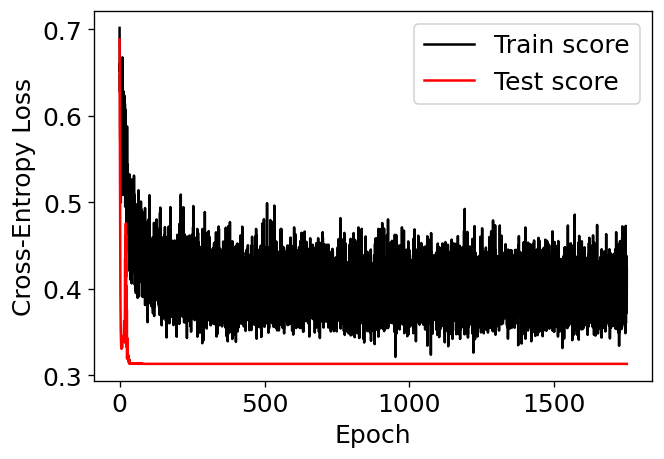

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:27<00:00, 20.11it/s]


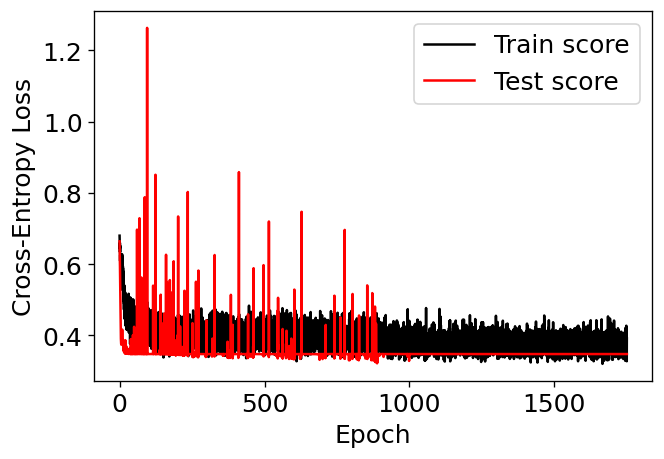

0.9655172413793104 -1
0.9655172413793104 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:31<00:00, 19.12it/s]


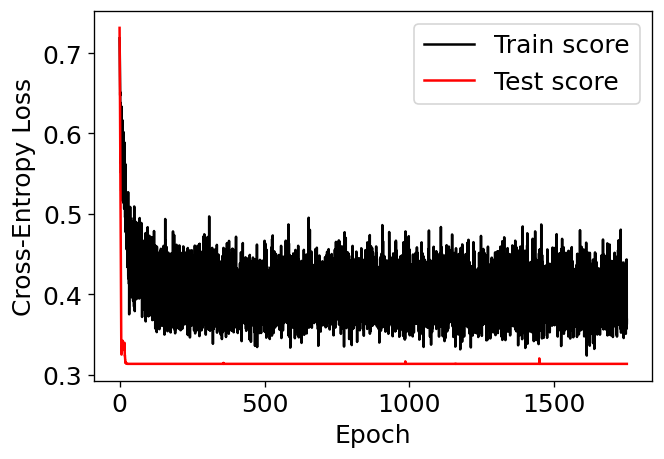

1.0 -1
1.0 -1.0
---------------------------------------------


100%|██████████| 1750/1750 [01:28<00:00, 19.87it/s]


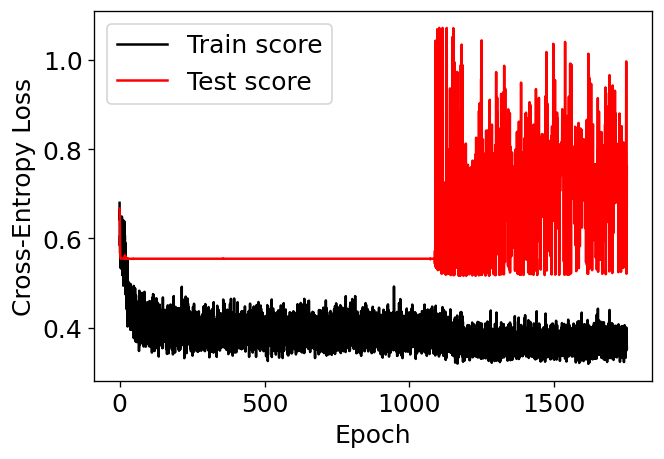

0.5689655172413793 -1
0.5689655172413793 0.2857142857142857
---------------------------------------------


100%|██████████| 1750/1750 [01:24<00:00, 20.74it/s]


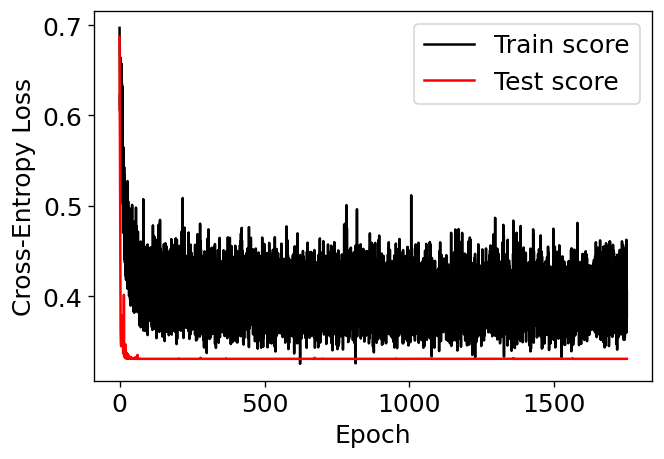

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:25<00:00, 20.35it/s]


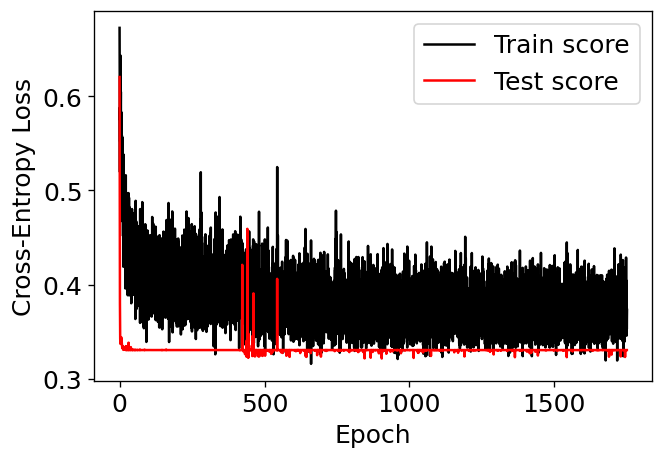

0.9827586206896551 -1
0.9827586206896551 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:26<00:00, 20.23it/s]


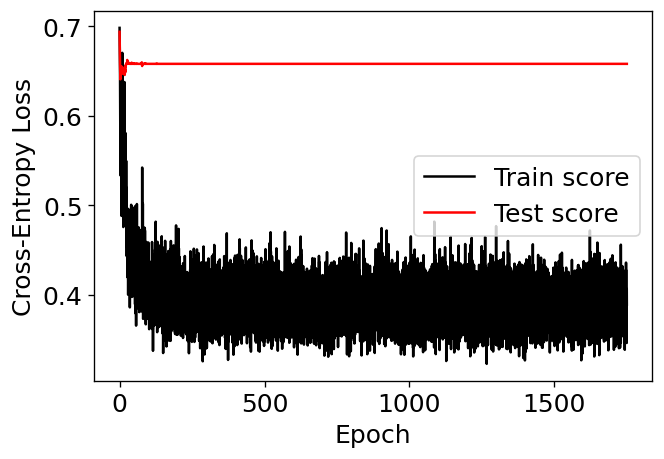

0.6551724137931034 -1
0.6551724137931034 0.0
---------------------------------------------


100%|██████████| 1750/1750 [01:25<00:00, 20.59it/s]


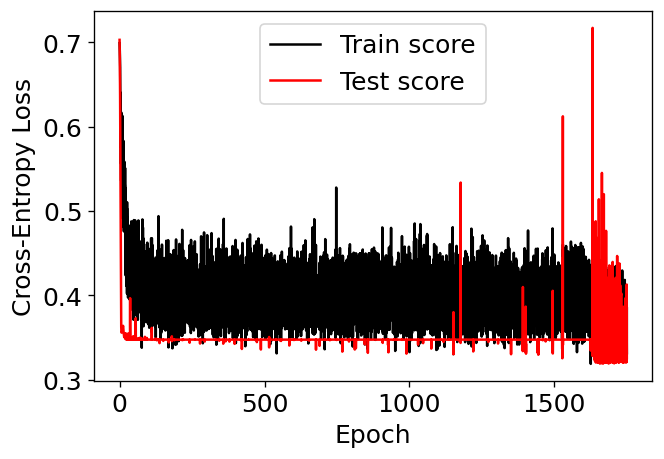

0.9827586206896551 -1
0.9827586206896551 0.9821428571428571
---------------------------------------------
ARCH = VDFCNN_6060_CNN1_CONN2
TP = 6.264705882352941+/-13.981729303818591
TN = 31.058823529411764+/-22.585707579157464
FP = 3.588235294117647+/-9.409374696542317
FN = 6.029411764705882+/-13.220939928581315
Acc = 0.866660669153788+/-0.20290373131899558
TSS = -0.2756229224245068+/-0.65009918025833
[1.         1.         0.34782609 0.91304348 0.89130435 0.91666667
 0.97826087 0.26666667 0.64102564 0.48648649 0.98275862 0.8630137
 0.72413793 0.96551724 0.98275862 0.55737705 0.85714286 1.
 0.95454545 1.         1.         1.         1.         1.
 1.         1.         1.         0.96551724 1.         0.56896552
 0.98275862 0.98275862 0.65517241 0.98275862]
[-1.         -1.         -0.33846154  0.9         0.         -1.
  0.          0.21428571  0.         -0.32714138  0.          0.
  0.          0.96491228  0.          0.          0.         -1.
  0.94736842 -1.         -1.         -

In [15]:
# NETWORK: VDFCNN_6060_CNN1_CONN2
ARCH = 'VDFCNN_6060_CNN1_CONN2'

tp = np.zeros([34], dtype=int)
tn = np.zeros([34], dtype=int)
fp = np.zeros([34], dtype=int)
fn = np.zeros([34], dtype=int)
acc = np.zeros([34], dtype=float)
tss = np.zeros([34], dtype=float)

for n_e, simfile in enumerate(simfiles):

  train_index = np.where(simnames != simfile)[0]
  test_index = np.where(simnames == simfile)[0]

  X_train, X_test = featurevector_allvdfs_all_6060_aug[train_index], featurevector_allvdfs_all_6060_aug[test_index]
  f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]

  while(True):

    # training the network
    device = torch.device("cuda:0")
    net = VDFCNN_6060_CNN1_CONN2().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

    loss_history_train = []
    loss_history_test = []

    outputs_history_train = []
    outputs_labels_train = []
    outputs_history_test = []
    outputs_labels_test = []

    n_epochs = 1750
    n_iterations = 7 # based on the total size / batch size, approximately

    # test data tensors
    testdata_tensor = torch.tensor(X_test).float().to(device=device)
    testlabels_tensor = torch.tensor(f_test).long().to(device=device)

    for ep in tqdm(range(n_epochs)):
      for n_iter in range (n_iterations):
        train_indexes = np.random.choice(X_train.shape[0], size=128, replace=False)
        traindata_tensor = torch.tensor(X_train[train_indexes]).float().to(device=device)
        trainlabels_tensor = torch.tensor(f_train[train_indexes]).long().to(device=device)
        outputs = net(traindata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, trainlabels_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history_train.append(loss.item())
        outputs_history_train.append(outputs.detach())
        outputs_labels_train.append(f_train[train_indexes])
        outputs = net(testdata_tensor)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(outputs, testlabels_tensor)
        loss_history_test.append(loss.item())
        outputs_history_test.append(outputs.detach())
        outputs_labels_test.append(f_test)

    # visualizing the result
    matplotlib.rcParams.update({'font.size': 15})
    im, ax = plt.subplots(1, 1, figsize=(6,4), dpi=120)
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_train, color='black', label='Train score')
    ax.plot(np.arange(n_epochs*n_iterations)/n_iterations, loss_history_test, color='red', label='Test score')
    ax.set(xlabel='Epoch', ylabel='Cross-Entropy Loss')
    ax.legend()
    plt.show()

    # finding the optimum
    optim_index = -1

    outputs_optim = outputs_history_test[optim_index]
    labels_optim = np.argmax(outputs_optim.cpu(), axis=1)

    _tp, _tn, _fp, _fn, _acc, _tss = outputclass_analysis_scorereturn_spec(f_test, labels_optim)

    print(_acc, optim_index)
    #if (_acc < 0.88):
      #print("RERUNNING THE SAMPLE...")
      #continue

    break

  tp[n_e], tn[n_e], fp[n_e], fn[n_e], acc[n_e], tss[n_e] = outputclass_analysis_scorereturn_spec(f_test, labels_optim)
  print(acc[n_e], tss[n_e])
  print('---------------------------------------------')

# final results
print("ARCH = " + str(ARCH))
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

print(acc)

print(tss)